# ***3. EARLY - FUSION***
# ⏰ **CONTINUACIÓN RE-ENTREGA**


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
import random

# Fijar semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

El modelo tiene un error absoluto de 56.76% respecto a valores reales en conjunto de validacion.

**Antes MSE (pérdida en test): 0.7009 MAE (error absoluto medio): 0.5972**


*Resultados en el conjunto de validación:*
Loss (Huber): 0.3898, MAE: 0.5676

*Resultados en el conjunto de prueba:*
Loss (Huber): 0.4033, MAE: 0.5972

Métricas en validacion y prueba son similares, tienen un MAE promedio bajo pero se puede mejorar.

# 🔼**Con estas métricas podemos hacer fusion de modelos pues la data tabular puede complementar muy bien este modelo de imagenes y permitir una mejora en predicciones al tener mas datos. Las imágenes por si solas no estan capturando la complejidad del problema de predicción de precios.**



# ***3. Fusión de modelos: Early Fusion***

Combinaré los datos en una unica entrada desde el inicio para que el modelo capture lreaciones de imagenes con datos tabulares e ir optimizando en conjunto. Ene ste punto tenemos data tabular e imagenes lista apra poder hacer el Early-Fusion.

Las imagenes pasan por un modelo re-entrenado, en este caso Resnet50 y se convierten en un vector comprimido de features de las imágenes.

Los datos de procesan por capas densas y generan otroa vector de Features.

Estos se concatenan y se pasan a una serie de capas densas que realizan la predicción final.

Luego se evalua funciones de perdida y optimizacion.

## **Cargar tabulares e imágenes**

**Variables:**

X_train, X_val, X_test: son los datos input del modelo, las Features que utilizaré para hacer las predicciones.

Como son datos de dos tipos, tabulares e imágenes, las viarables quedarian asi:

**Inputs:**

Imágenes: X_train_imgs, X_train_imgs, X_test_imgs
Tabulares: X_train_tab, X_val_tab, X_test_tab


**Output:**
Y_train, Y_val, Y_test

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Cargar datos tabulares
fd_train = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_train_finpreprocesado.csv", sep=';')
fd_val = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_val_finpreprocesado.csv", sep=';')
fd_test = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_test_finpreprocesado.csv", sep=';')

# Cargar imágenes normalizadas y redimensionadas
X_train_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_128.npy")
X_val_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_128.npy")
X_test_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_128.npy")

# Verificar shapes para confirmar
print(f"Shape datos tabulares (train): {fd_train.shape}")
print(f"Shape imágenes (train): {X_train_imgs.shape}")
print(f"Shape datos tabulares (val): {fd_val.shape}")
print(f"Shape imágenes (val): {X_val_imgs.shape}")
print(f"Shape datos tabulares (test): {fd_test.shape}")
print(f"Shape imágenes (test): {X_test_imgs.shape}")


Shape datos tabulares (train): (2125, 36)
Shape imágenes (train): (2125, 128, 128, 3)
Shape datos tabulares (val): (376, 36)
Shape imágenes (val): (376, 128, 128, 3)
Shape datos tabulares (test): (627, 36)
Shape imágenes (test): (627, 128, 128, 3)


In [ ]:
# Cargar las etiquetas (target)
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")

# Verificar formas de las etiquetas
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_val: {y_val.shape}")
print(f"Shape de y_test: {y_test.shape}")


Shape de y_train: (2125,)
Shape de y_val: (376,)
Shape de y_test: (627,)


## **Cargar tabulares e imágenes**

Las formas coinciden perfectamente entre cada conjunto y ahora escalaré los tabulares a la misma escala de las imágenes, pues estas al pasar por ResNet50 su preprocesamiento las convierte en un rango de (-1 a 1).


Los datos tabulares se ecalan a una media de 0 y desviacion de 1 para que las escalas sean comparables antes de fusionar.

In [ ]:
# Escalar los datos tabulares
scaler = StandardScaler()

# Escalar train, val y test
X_train_tab = scaler.fit_transform(fd_train)
X_val_tab = scaler.transform(fd_val)
X_test_tab = scaler.transform(fd_test)

# Verificar shapes después de escalar
print(f"Shape datos tabulares escalados (train): {X_train_tab.shape}")
print(f"Shape datos tabulares escalados (val): {X_val_tab.shape}")
print(f"Shape datos tabulares escalados (test): {X_test_tab.shape}")


Shape datos tabulares escalados (train): (2125, 36)
Shape datos tabulares escalados (val): (376, 36)
Shape datos tabulares escalados (test): (627, 36)


# **Construcción de modelo Early Fusion**

Combinación de features de imágenes obtenidas a tra ves de ResNet con datos tabulares escalados.

Flujo:

1. ResNet50 procesará las imágenes y generará características (vectores)
2. Las características se concatenaran con los datos tabulares escalados.
3. El output del combinado se pasará a capas Dense adicionales para generar predicciones.

## **El modelo se fusiona mediante la capa: Concatenate**

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# 1. Entrada de imágenes y ResNet50
input_imgs = Input(shape=(128, 128, 3), name="input_imgs")
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=input_imgs)
x = Flatten()(resnet.output)  # Aplanar la salida de ResNet50

# Congelar las capas de ResNet50
for layer in resnet.layers:
    layer.trainable = False

# 2. Entrada de datos tabulares
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")

# 3. Concatenación y capas densas
# Combinar características de ResNet50 con los datos tabulares
combined = Concatenate()([x, input_tabular])
combined = Dense(256, activation="relu")(combined)
combined = Dropout(0.5)(combined)
combined = Dense(128, activation="relu")(combined)
combined = Dropout(0.5)(combined)

# 4. Output
output = Dense(1, activation="linear", name="output")(combined)

# 5. Modelo Final
model = Model(inputs=[input_imgs, input_tabular], outputs=output)

# Compilar el modelo
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Resumen del modelo
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_imgs (InputLayer)   │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_imgs[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 32,018,817 (122.14 MB)

 Trainable params: 8,431,105 (32.16 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 El modelo esta configurado con un total de 32.018.817 prámetros de los cuales 8.431.105 son entrenables, de las capas densas agregadas y tabulares, y 23.587.712 son congeladas de ResNet50.

 **Reutilizaré las características pre-entrenadas sin recalibrar toda la red neuronal.**

# **Entrenamiento del modelo Early - Fusion**

Imágenes (X_train_imgs, X_val_imgs).

Datos tabulares escalados (X_train_tab, X_val_tab).

Configuraciones:
Epochs = 20

Batch size = 32

Validación = conjunto val


In [ ]:
# Configuración del entrenamiento
batch_size = 32
epochs = 20

# Entrenar el modelo
history = model.fit(
    [X_train_imgs, X_train_tab],  # Inputs
    y_train,                      # Output
    validation_data=([X_val_imgs, X_val_tab], y_val),  # Validación
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - loss: 5.4498 - mae: 1.8367 - val_loss: 1.0665 - val_mae: 0.8681
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - loss: 2.0381 - mae: 1.1193 - val_loss: 3.5527 - val_mae: 1.8108
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - loss: 1.9642 - mae: 1.1196 - val_loss: 3.7441 - val_mae: 1.8652
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - loss: 1.5297 - mae: 0.9849 - val_loss: 3.3967 - val_mae: 1.7692
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - loss: 1.4540 - mae: 0.9436 - val_loss: 3.6116 - val_mae: 1.8394
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - loss: 1.3327 - mae: 0.9097 - val_loss: 4.1489 - val_mae: 1.9743
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - loss: 1.2590 - mae: 0.8919 - val_loss: 2.4450 - val_mae: 1.4916
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - loss: 1.2997 - mae: 0.9070 - val_loss: 4.4167 - val_mae: 2.0453
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - loss: 1.143

# **Evaluación del modelo Early - Fusion**

In [ ]:
# Evaluar el modelo en el conjunto de prueba
results = model.evaluate(
    [X_test_imgs, X_test_tab],  # Inputs de prueba
    y_test,                     # Output esperado
    verbose=1
)

# Mostrar resultados
print(f"Resultados en Test - Loss (MSE): {results[0]}, MAE: {results[1]}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 3.9028 - mae: 1.9181
Resultados en Test - Loss (MSE): 3.849189519882202, MAE: 1.903609275817871


## **Visualizacion de métricas modelo Early-Fusion**

In [ ]:
import matplotlib.pyplot as plt

# Obtener los datos del historial
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Crear gráficos
# 1. Gráfico de Loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Train Loss (MSE)')
plt.plot(val_loss, label='Validation Loss (MSE)')
plt.title('Loss (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

# 2. Gráfico de MAE
plt.figure(figsize=(10, 5))
plt.plot(mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()


## **Análisis gráficos MSE y MAE Early-Fusion**

Train Loss: MSE disminuye constantemente, el modeo esta prendiendo bien en el conjunto de entrenamiento.

Val-loss: MAE No sigue la misma tendencia, fluctua bastante y no mejora, hay sobreajuste.

El modelo esta memorando los datos del trainign en lugar de aprender patrones que funciones con los datos nuevos.

20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step


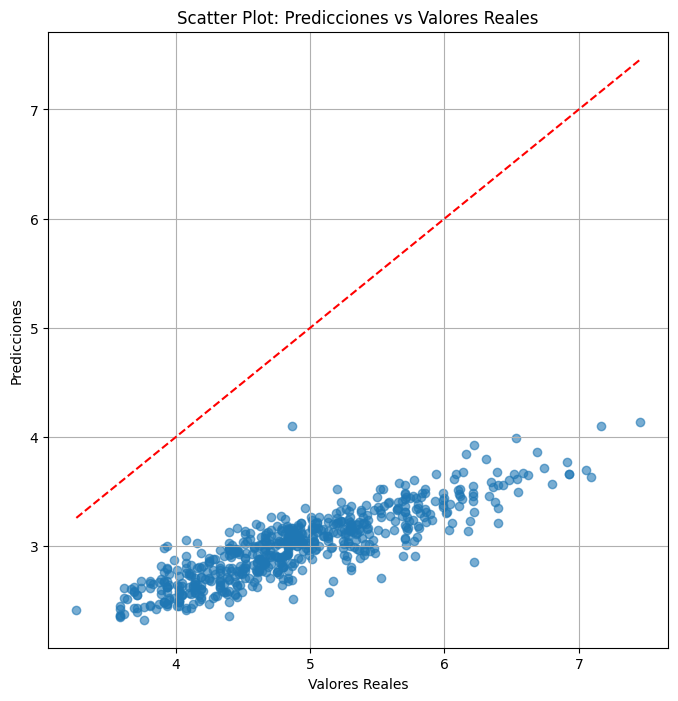

In [ ]:
# Generar predicciones en el conjunto de prueba
y_pred = model.predict([X_test_imgs, X_test_tab])

# Crear gráfico de dispersión
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea ideal
plt.grid()
plt.show()


## **Análisis scatter plot predicciones vs. valores reales, Early-Fusion**

La mayoría depuntos esta por debajo dela linea roja, el modelo esta subestimando los valores reales y predecirá precios mas bajos que los reales.

La correlacion de puntos es buena y van en ascendencia pero sigue con problemas de ajustarse a valores mas altos.

Modelo:

puede ser demasiado simple y las capas no son suficientes, pueden faltar datos y no generaliza bien en prueba.


# **Plan para ajustar el modelo Early-Fusion:**

1. Configurar el EarlyStopping para que el modelo se detenga cuando el modelo no este mejorando y evitar que el modelo se sobre-entrene y mejoré su capacidad de generalización.

2. Dropout, modificarlo, actualmente tiene 50%, 0.5, lo subiré a 0.6 en las capas densas para que reduzca la dependencia del modelo en ciertas neuronas especificas y que generalice mejor.

## **EarlyStopping:**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea el loss de validación
    patience=5,          # Permite hasta 5 épocas sin mejora
    restore_best_weights=True  # Restaura los mejores pesos del modelo
)


## **Incrementar dropout - Early Fusion Ajustado:**

In [ ]:
# Ajustar las capas densas para incrementar Dropout
combined = Dense(256, activation="relu")(combined)
combined = Dropout(0.6)(combined)  # Incrementamos Dropout a 60%
combined = Dense(128, activation="relu")(combined)
combined = Dropout(0.6)(combined)  # Incrementamos Dropout a 60%

# Salida
output = Dense(1, activation="linear", name="output")(combined)

# Crear el modelo final con los ajustes
model = Model(inputs=[input_imgs, input_tabular], outputs=output)

# Compilar el modelo con los ajustes
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


## **Re-entrenar modelo - Early Fusion Ajustado:**

In [ ]:
history = model.fit(
    [X_train_imgs, X_train_tab],  # Inputs
    y_train,                      # Etiquetas de entrenamiento
    validation_data=([X_val_imgs, X_val_tab], y_val),  # Datos de validación
    batch_size=batch_size,
    epochs=50,  # Más épocas, ya que Early Stopping detendrá el entrenamiento si es necesario
    callbacks=[early_stopping],  # Callback de Early Stopping
    verbose=1
)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - loss: 13.2453 - mae: 2.7516 - val_loss: 7.5506 - val_mae: 2.7049
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - loss: 3.2436 - mae: 1.4516 - val_loss: 7.4906 - val_mae: 2.6593
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - loss: 2.2344 - mae: 1.2060 - val_loss: 2.5968 - val_mae: 1.4187
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - loss: 1.7774 - mae: 1.0457 - val_loss: 1.1962 - val_mae: 0.8603
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 1.5517 - mae: 0.9876 - val_loss: 1.1329 - val_mae: 0.8529
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 1.5124 - mae: 0.9692 - val_loss: 0.9840 - val_mae: 0.7909
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 1.4978 - mae: 0.9609 - val_loss: 0.9346 - val_mae: 0.7648
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - loss: 1.3276 - mae: 0.9113 - val_loss: 0.8737 - val_mae: 0.7510
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - loss: 1.19

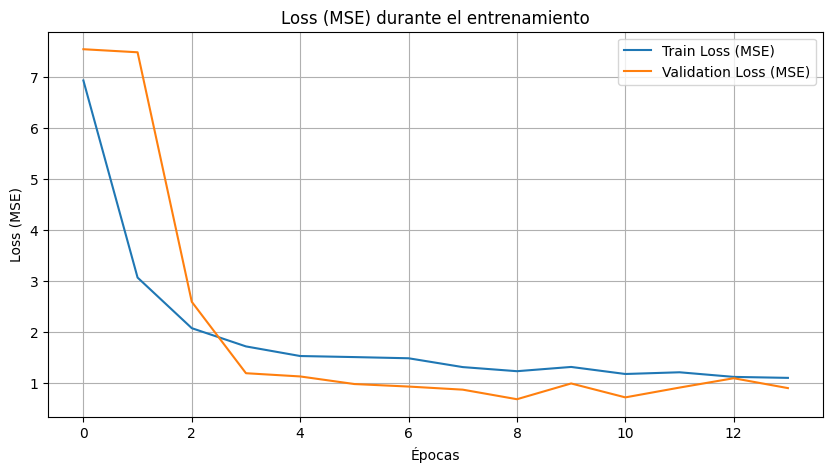

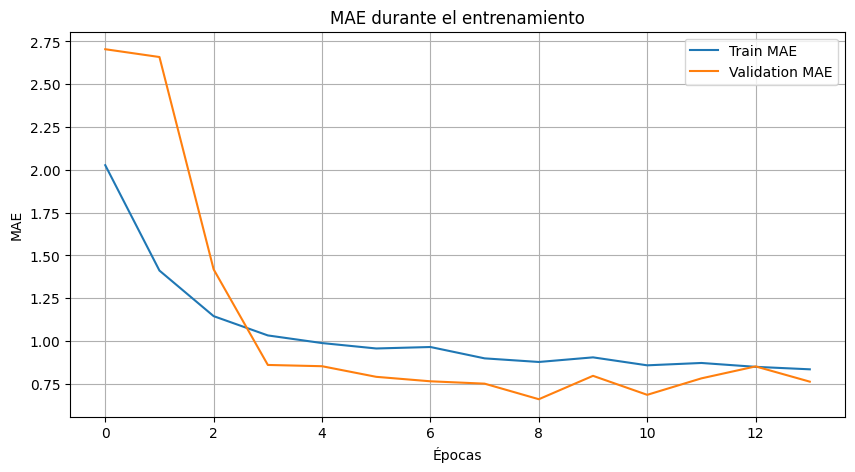

In [ ]:
import matplotlib.pyplot as plt

# Obtener métricas del historial
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

# 1. Gráfico de Loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Train Loss (MSE)')
plt.plot(val_loss, label='Validation Loss (MSE)')
plt.title('Loss (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

# 2. Gráfico de MAE
plt.figure(figsize=(10, 5))
plt.plot(mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()


## **Análisis gráfico MSE - Early Fusion Ajustado:**

El train loss disminuye constantemente a medida que el modelo aprende, se estabiliza cerca de 1.0 des pues de unas pocas épocas.

Validation Loss dimisnuye y se mantiene cercano al train loos, earlystoppping y dropout ayudaron a reducir el sobre ajuste. El modelo parece generalizar mejor ahora.

## **Análisis gráfico - Early Fusion Ajustado:**

El MAE en trian sigeu una tendencia descendente contante y se estabiliza en 0.7 y 0.8 similar a Val MAE.

20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step


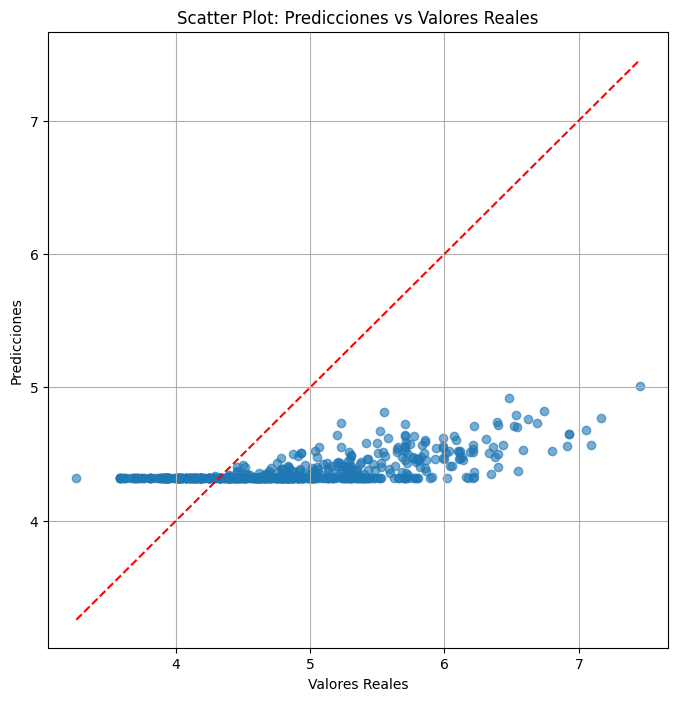

In [ ]:
# Generar predicciones en el conjunto de prueba
y_pred = model.predict([X_test_imgs, X_test_tab])

# Crear scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea ideal
plt.grid()
plt.show()



## **Análisis gráfico scatter plot  - Early Fusion Ajustado:**

Ahora los puntos estan cercano a la linea roja, se agrupan en la parte baje deñ grafico (4.0 y 5.0) puede haber sesgo hacia valores bajos.

Se muestra un aplanamiento claro y con poco variabilidad que no esta aprovechando el rango de valores reales.


***Posibles causas:***

Le modelo puede no estar capturando toda la complejidad de tabulares e imágenes?

El uso de MSE esta penalizando valores atípicos, haciendo que el modelo sea mas conservador?

El dropout ayudo a reducir sobreajuste pero pudo haber limitado tambien la capcidad?

***Plan:***

Cambiar funcion de perdida a Huber Loss para ver si ayuda reduciendo la subestimación y mejora la variabilidad de datos.

In [ ]:

# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Cargar datos tabulares
fd_train = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_train_finpreprocesado.csv", sep=';')
fd_val = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_val_finpreprocesado.csv", sep=';')
fd_test = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_test_finpreprocesado.csv", sep=';')

# Cargar imágenes normalizadas y redimensionadas
X_train_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_128.npy")
X_val_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_128.npy")
X_test_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_128.npy")

# Cargar las etiquetas
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")

# Escalar datos tabulares
scaler = StandardScaler()
X_train_tab = scaler.fit_transform(fd_train)
X_val_tab = scaler.transform(fd_val)
X_test_tab = scaler.transform(fd_test)

# Verificar shapes para evitar errores
print("Datos Tabulares:")
print(f"Train tabular: {X_train_tab.shape}")
print(f"Validation tabular: {X_val_tab.shape}")
print(f"Test tabular: {X_test_tab.shape}")

print("\nDatos de Imágenes:")
print(f"Train imágenes: {X_train_imgs.shape}")
print(f"Validation imágenes: {X_val_imgs.shape}")
print(f"Test imágenes: {X_test_imgs.shape}")

print("\nEtiquetas:")
print(f"Train etiquetas: {y_train.shape}")
print(f"Validation etiquetas: {y_val.shape}")
print(f"Test etiquetas: {y_test.shape}")



Datos Tabulares:
Train tabular: (2125, 36)
Validation tabular: (376, 36)
Test tabular: (627, 36)

Datos de Imágenes:
Train imágenes: (2125, 128, 128, 3)
Validation imágenes: (376, 128, 128, 3)
Test imágenes: (627, 128, 128, 3)

Etiquetas:
Train etiquetas: (2125,)
Validation etiquetas: (376,)
Test etiquetas: (627,)


## **Implementación de Huber Loss  - Early Fusion Ajustado 2**

In [ ]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

# Entrada de imágenes y ResNet50
input_imgs = Input(shape=(128, 128, 3), name="input_imgs")
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=input_imgs)
x = Flatten()(resnet.output)

# Congelar capas de ResNet50
for layer in resnet.layers:
    layer.trainable = False

# Entrada de datos tabulares
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")

# Concatenar características de ResNet50 con los datos tabulares
combined = Concatenate()([x, input_tabular])
combined = Dense(256, activation="relu")(combined)
combined = Dropout(0.5)(combined)  # Dropout ajustado
combined = Dense(128, activation="relu")(combined)
combined = Dropout(0.5)(combined)  # Dropout ajustado
combined = Dense(64, activation="relu")(combined)  # Nueva capa densa

# Salida
output = Dense(1, activation="linear", name="output")(combined)

# Crear el modelo ajustado
model = Model(inputs=[input_imgs, input_tabular], outputs=output)

# Compilar el modelo con Huber Loss
model.compile(optimizer="adam", loss=Huber(), metrics=["mae"])

# Resumen del modelo
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_imgs (InputLayer)   │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_imgs[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 32,027,009 (122.17 MB)

 Trainable params: 8,439,297 (32.19 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# **Re-entrenamiento con cambio de parámetros - Huber Loss - Early Fusion Ajustado 2**


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entrenar el modelo ajustado
history = model.fit(
    [X_train_imgs, X_train_tab],
    y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - loss: 0.6815 - mae: 1.0868 - val_loss: 2.2062 - val_mae: 2.7062
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - loss: 0.5453 - mae: 0.9356 - val_loss: 2.2986 - val_mae: 2.7986
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - loss: 0.4960 - mae: 0.8810 - val_loss: 2.1763 - val_mae: 2.6763
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 0.4525 - mae: 0.8312 - val_loss: 2.2798 - val_mae: 2.7798
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - loss: 0.3835 - mae: 0.7490 - val_loss: 2.2634 - val_mae: 2.7634
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - loss: 0.3258 - mae: 0.6726 - val_loss: 2.3996 - val_mae: 2.8996
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - loss: 0.2875 - mae: 0.6223 - val_loss: 2.2315 - val_mae: 2.7315
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 0.2612 - mae: 0.5957 - val_loss: 2.2755 - val_mae: 2.7755


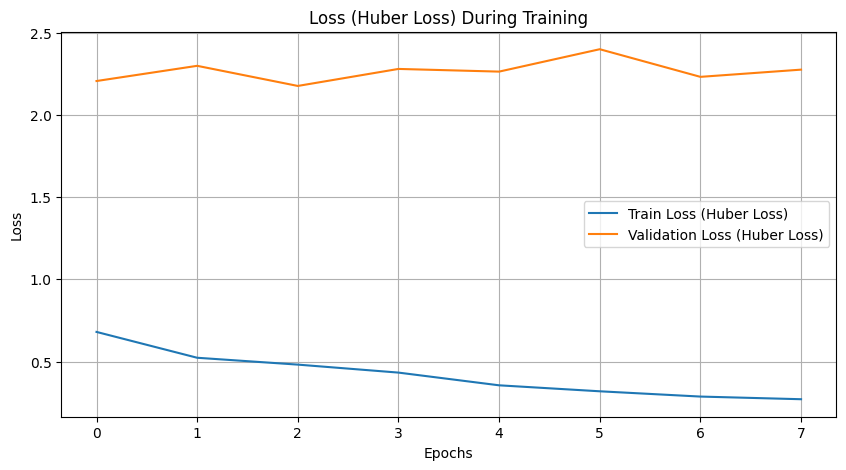

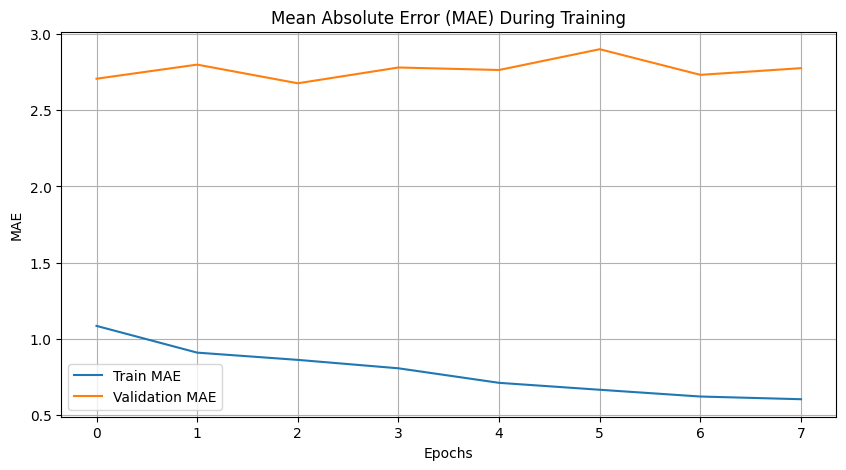

In [ ]:
import matplotlib.pyplot as plt

# Historial métricas
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Train Loss (Huber Loss)')
plt.plot(val_loss, label='Validation Loss (Huber Loss)')
plt.title('Loss (Huber Loss) During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot MAE
plt.figure(figsize=(10, 5))
plt.plot(mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error (MAE) During Training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()



## **Análisis gráfico MAE y Huber Loss - Early Fusion Ajustado 2:**

La linea de train loss (huber loss) muestra disminución constante indicando que el modelo esta aprendiendo y ajustando bien los datos de entrenamiento.

Val loss es plana y sin mejora, el modeo no esta generalizando bien en val.

**MAE**

Train MAE descendente y estabilizandose con datos train.
Val MAE se mantiene alta, tampoco mejora par alos datos de val.




## **Visualización gráfico scatter plot Huber Loss - Early Fusion Ajustado 2**


20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step


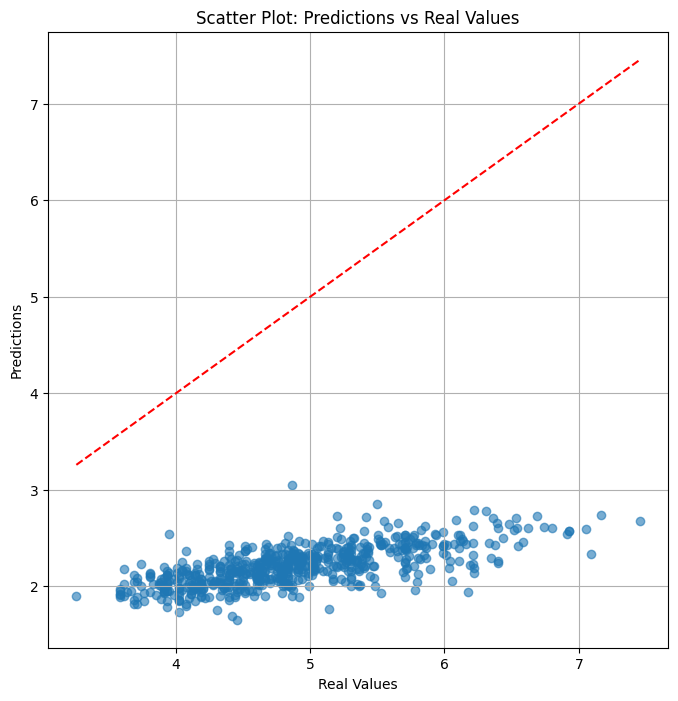

In [ ]:
# Predicciones en test
y_pred = model.predict([X_test_imgs, X_test_tab])

# Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predictions vs Real Values")
plt.xlabel("Real Values")
plt.ylabel("Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
plt.grid()
plt.show()



## **Análisis gráfico scatter plot Huber Loss - Early Fusion Ajustado 2:**
Las predicciones vuelve a quedar por debajo dela línea roja y ademas estan aplanadas, subestimando consistetemente los valores reales. No se captura bien la variabilidad de datos. Sesgo fuerte a predicciones bajas.

## **Plan:**

Re-estructuraré la arquitectura del modelo pues no esta teniendo la capacidad de capturar relaciones complejas entre imágenes y datos.

Agregaré mas capas densas para mas profundidad y que el modelo aprenda patrones mas compleojos.

Incorporaré batch normalization para estabilizar y acelerar el aprendizaje en redes profundas.

Incrementaré el peso relativo de los tabulares para priorizar features que tienen la info directa para predecir precios.

Entrenaré con earlystopping.

Haré un test con ELU, es util cuando el modelo tiene varias capas densas y necesita aprender relaciones sutiles. Tambien mejora la convergencia con problemas de relaciones de un label con multiples variables interconectadas.

## **Entrenamiento modelo Early Fusion - ELU + Capas densas + Batch Norm +EarlyStopping Ajustado 3**

In [ ]:
from tensorflow.keras.layers import ELU, BatchNormalization, Dense, Dropout, Flatten, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber

# Entrada de imágenes y ResNet50
input_imgs = Input(shape=(128, 128, 3), name="input_imgs")
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=input_imgs)
x = Flatten()(resnet.output)

# Congelar capas de ResNet50
for layer in resnet.layers:
    layer.trainable = False

# Entrada de datos tabulares
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")

# Concatenar características de ResNet50 con los datos tabulares
combined = Concatenate()([x, input_tabular])

# Red con ELU
combined = Dense(512)(combined)
combined = BatchNormalization()(combined)
combined = ELU()(combined)  # Activación ELU
combined = Dropout(0.4)(combined)

combined = Dense(256)(combined)
combined = BatchNormalization()(combined)
combined = ELU()(combined)  # Activación ELU
combined = Dropout(0.4)(combined)

combined = Dense(128)(combined)
combined = BatchNormalization()(combined)
combined = ELU()(combined)  # Activación ELU
combined = Dropout(0.4)(combined)

# Salida
output = Dense(1, activation="linear", name="output")(combined)

# Crear el modelo
model = Model(inputs=[input_imgs, input_tabular], outputs=output)

# Compilar el modelo con Huber Loss
model.compile(optimizer="adam", loss=Huber(), metrics=["mae"])

# Resumen del modelo
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_imgs (InputLayer)   │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_imgs[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 40,551,809 (154.69 MB)

 Trainable params: 16,962,305 (64.71 MB)

 Non-trainable params: 23,589,504 (89.99 MB)

In [ ]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    [X_train_imgs, X_train_tab],  # Entradas
    y_train,                      # Etiquetas
    validation_data=([X_val_imgs, X_val_tab], y_val),  # Validación
    batch_size=32,                # Tamaño del batch
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - loss: 3.4413 - mae: 3.9352 - val_loss: 0.6542 - val_mae: 1.0411
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - loss: 1.4973 - mae: 1.9477 - val_loss: 0.4395 - val_mae: 0.8067
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - loss: 0.9118 - mae: 1.3309 - val_loss: 0.4816 - val_mae: 0.8516
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - loss: 0.8534 - mae: 1.2658 - val_loss: 0.4645 - val_mae: 0.8575
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - loss: 0.7260 - mae: 1.1319 - val_loss: 0.2480 - val_mae: 0.5671
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - loss: 0.7278 - mae: 1.1341 - val_loss: 0.2224 - val_mae: 0.5366
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - loss: 0.6959 - mae: 1.0970 - val_loss: 0.1849 - val_mae: 0.4798
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - loss: 0.5901 - mae: 0.9809 - val_loss: 0.2434 - val_mae: 0.5885
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - loss: 0.536

## **Entrenamiento del modelo con ELU y Huber Loss - Early Fusion ajustado 3**

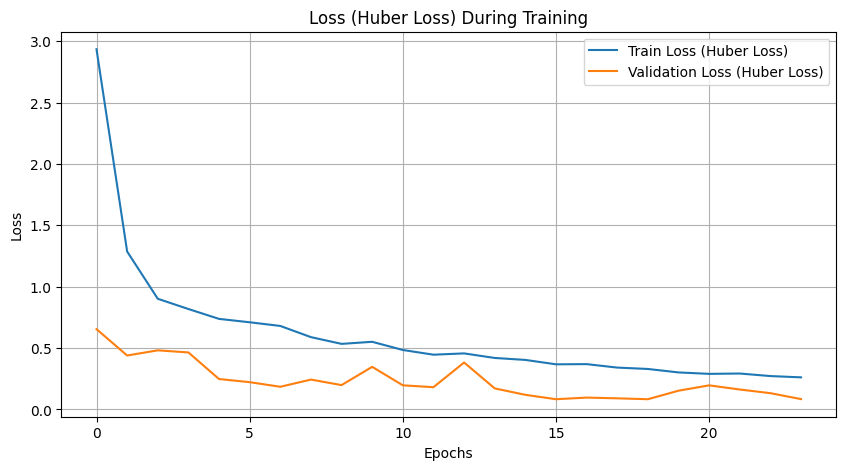

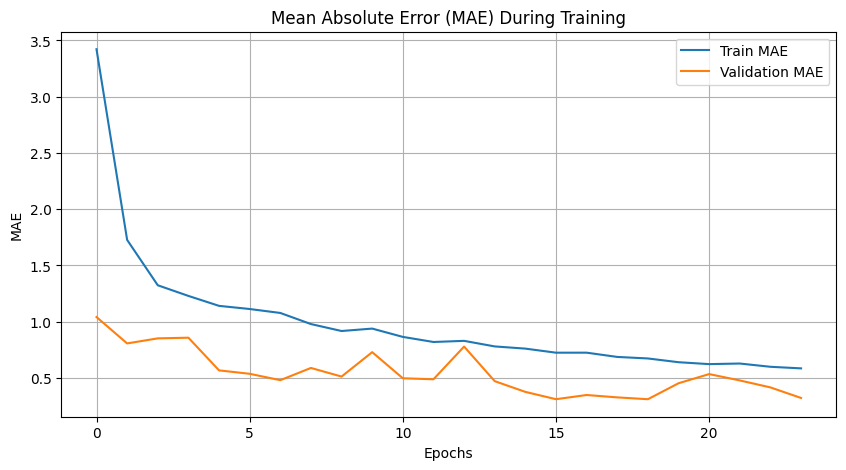

In [ ]:
import matplotlib.pyplot as plt

# Historial métricas
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Train Loss (Huber Loss)')
plt.plot(val_loss, label='Validation Loss (Huber Loss)')
plt.title('Loss (Huber Loss) During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot MAE
plt.figure(figsize=(10, 5))
plt.plot(mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error (MAE) During Training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()


## **Análisis Métricas ELU - Huber Loss - Early Fusion Ajustado 3**

**Grafico Huber Loss:**
Train loss dismunye de manera consistenete, se estabiliza en un valor bajo 0.2. EL modelo esta aprendiendo bien en el conjunto de entrenamiento.

**Validation Loss:**
Dismunye de forma cosntante y se mantiene cerca de la perdida de entrenamiento. Hay una mejora de generalizacion con este modelo sin sobreajustes.


**MAE:**
Train MAE disminuye rapidamente y alcanza vaores bajos entre 0.3 y 0.4, esto es bueno para el entrenamiento.

**Validation MAE:**
Disminuye consistentemente, va estabilizandose en un rango aceptable 0.5. El modelo ahora puede hacer predicciones mucho mas precisas en el conjunto de validación. Comete mucho menos errores que antes.


20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


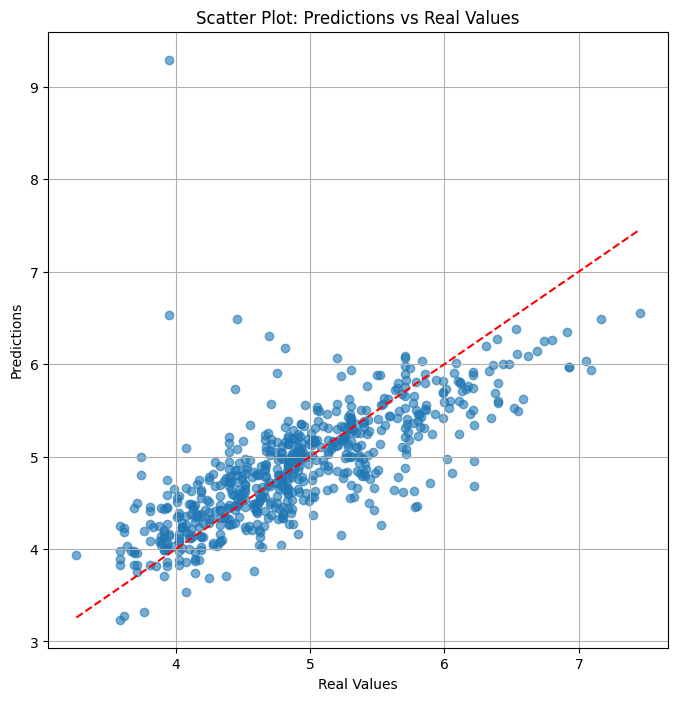

In [ ]:
# Predicciones en test
y_pred = model.predict([X_test_imgs, X_test_tab])

# Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predictions vs Real Values")
plt.xlabel("Real Values")
plt.ylabel("Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
plt.grid()
plt.show()


## **Análisis Scatter plot modelo ELU - Huber Loss - Early Fusion Ajustado 3**

**Distribución:** los puntos estan mas alineados con la linea roja, esto indica que se obtienen predicciones mas precisas.
Se ve todavia errores pero no como con los modelos anteriores.

**Rango de predicción:** ahora cubre mucho mejor el rango de valores reales evitando la subestmiacion de los modelos previos. Loas valores altos estan mejor capturados.

## **Reconstrucción modelo Elu - Early Fusion Ajustado 4**

In [ ]:
# Reconstruir el modelo con ELU y Batch Normalization
input_imgs = Input(shape=(128, 128, 3), name="input_imgs")
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=input_imgs)
x = Flatten()(resnet.output)

# Congelar capas de ResNet50
for layer in resnet.layers:
    layer.trainable = False

# Entrada tabular
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")

# Concatenar
combined = Concatenate()([x, input_tabular])
combined = Dense(512)(combined)
combined = BatchNormalization()(combined)
combined = ELU()(combined)
combined = Dropout(0.4)(combined)

combined = Dense(256)(combined)
combined = BatchNormalization()(combined)
combined = ELU()(combined)
combined = Dropout(0.4)(combined)

combined = Dense(128)(combined)
combined = BatchNormalization()(combined)
combined = ELU()(combined)
combined = Dropout(0.4)(combined)

# Salida
output = Dense(1, activation="linear")(combined)

# Crear el modelo
model = Model(inputs=[input_imgs, input_tabular], outputs=output)

# Compilar el modelo
model.compile(optimizer="adam", loss=Huber(), metrics=["mae"])

# Resumen del modelo
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_imgs (InputLayer)   │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_imgs[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 40,551,809 (154.69 MB)

 Trainable params: 16,962,305 (64.71 MB)

 Non-trainable params: 23,589,504 (89.99 MB)

In [ ]:
# Guardar el modelo
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/ResNet50_model_ELU_huber.keras")
print("Modelo guardado correctamente como ResNet50_model_ELU_huber")


Modelo guardado correctamente como ResNet50_model_ELU_huber


In [ ]:
model.summary()  # Confirmar que el modelo en memoria es el correcto


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_imgs (InputLayer)   │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_imgs[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 40,551,809 (154.69 MB)

 Trainable params: 16,962,305 (64.71 MB)

 Non-trainable params: 23,589,504 (89.99 MB)

# **Evaluación modelo en Test ELU - Huber - Early Fusion Ajustado 4**

20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 3.9123 - mae: 4.4123
Resultados en Test - Loss (Huber Loss): 3.923175096511841, MAE: 4.42317533493042
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


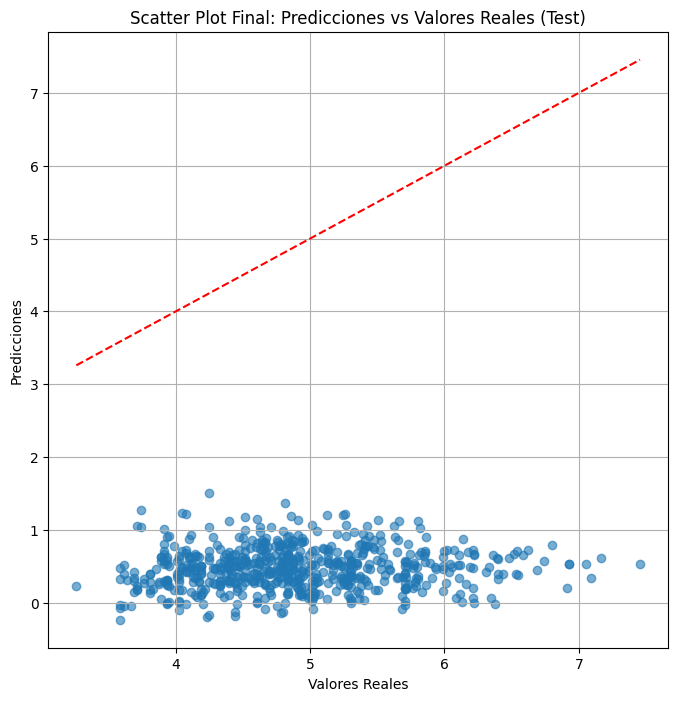

In [ ]:
# Evaluar el modelo en el conjunto de prueba
results = model.evaluate([X_test_imgs, X_test_tab], y_test, verbose=1)
print(f"Resultados en Test - Loss (Huber Loss): {results[0]}, MAE: {results[1]}")

# Generar predicciones en el conjunto de prueba
y_pred_test = model.predict([X_test_imgs, X_test_tab])

# Scatter Plot Final
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.title("Scatter Plot Final: Predicciones vs Valores Reales (Test)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea ideal
plt.grid()
plt.show()


# **Desempeño del modelo ELU- Huber  - Early Fusion Ajustado 4 en Test**


**Distribución:**

Ls predicciones son extremendamente bajas y alejadas de los valores reales. El modelo no logró capturar la relación entre las features y valores reales en el conjunto de prueba.

**Métricas Loss y MAE:**

Los valores son peores que los obtenidos durante entrenamiento y validación. El modelo falla totalmente al generalizar en datos nunca vistos.

Hay desbalance fuerte entre entrenamiento y prueba.



***Verificaré la dsitribucion y si fallo algo en el Scaler de las etiquetas en los datos de prueba para ver si estan totalmente distintos.***

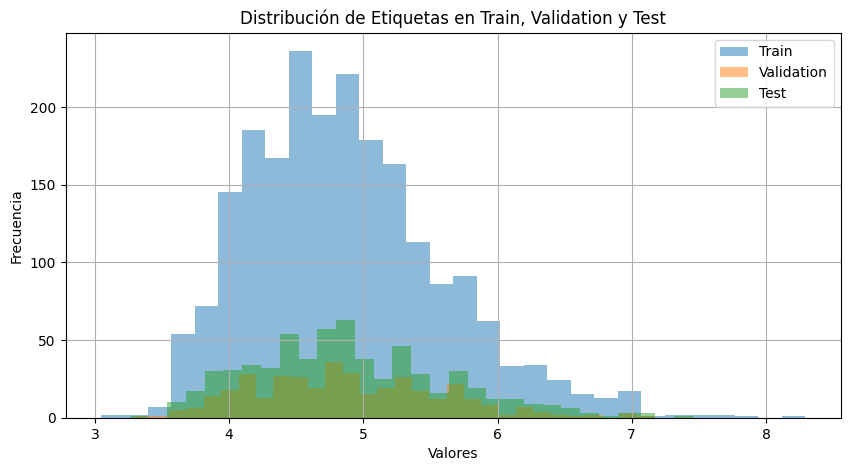

In [ ]:
import matplotlib.pyplot as plt

# Histograma de etiquetas
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=30, alpha=0.5, label='Train')
plt.hist(y_val, bins=30, alpha=0.5, label='Validation')
plt.hist(y_test, bins=30, alpha=0.5, label='Test')
plt.title("Distribución de Etiquetas en Train, Validation y Test")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid()
plt.show()


In [ ]:
print("Primeras filas de datos tabulares en test después del escalado:")
print(X_test_tab[:5])


Primeras filas de datos tabulares en test después del escalado:
[[ 4.23195396e-01  3.21379399e-01  5.52401940e-01  1.42830572e+00
  -3.19360615e-01  1.06879052e-01  3.29397737e-01 -2.17851883e-02
   2.99819030e-01 -6.00131775e-01  8.17052588e-01 -3.28410955e-01
   1.18630869e+00  1.18115160e-01  6.81783226e-01  1.35515679e-01
   7.12746796e-01  6.50279869e-01 -4.07013848e-01  4.50260058e-02
  -5.82501816e-01 -7.18495542e-04 -1.24335746e-01  6.52032516e-01
  -1.22676255e+00  4.62510073e-01  7.16977250e-01  3.08541187e-01
  -6.44034388e-01  1.97510404e-01 -5.66300348e-01  1.77394746e+00
  -7.04211097e-03  3.08774355e-01  6.84955264e-01  1.98829560e-01]
 [-1.27678611e+00  3.21379399e-01 -9.71579674e-01  1.42830572e+00
   8.75844797e-01  1.06879052e-01  3.29397737e-01  1.42900905e+00
   5.41374698e-01  1.21812272e+00 -8.48885806e-02 -3.28410955e-01
   2.65934113e-01  1.18115160e-01  6.81783226e-01  1.35515679e-01
   7.12746796e-01 -1.04840233e-01 -2.28077107e-01  2.71678075e-01
  -5.825018

In [ ]:
# Verificar la alineación entre datos tabulares y de imágenes
print(f"Shape datos tabulares (test): {fd_test.shape}")
print(f"Shape imágenes (test): {X_test_imgs.shape}")


Shape datos tabulares (test): (627, 36)
Shape imágenes (test): (627, 128, 128, 3)


## **Análisis distribuciones y escalado tabular e Imágenes**

Las distribuciones son similares en train validation y test. No tenemos problema de distribución entre conjuntos.

**Scaler:**

Los valores se muestran correctamente escalados, consistentes.


***Revisaré otra arquitectura del modelo de imágenes que aunque funcionó  muy bien en validación puede estar sobre ajustado a al conjunto de entrenamiento/validación fallando en extrapolar a datos nuevos.***


**Revisión de la interaccion imágen-tabular**

Ajustaré el modelo para dar mayor peso a las features tabulares por que tienen info mas directa para problemas de predicción como este.

In [ ]:
# Redefinir la concatenación con un enfoque más tabular
combined = Dense(128, activation="relu")(input_tabular)  # Más peso a tabular
combined = Concatenate()([x, combined])  # Concatenar después de procesamiento tabular
combined = Dense(256)(combined)
combined = BatchNormalization()(combined)
combined = ELU()(combined)
combined = Dropout(0.4)(combined)


**Verificare que el problema radica en la combinacion de imagenes con tabular pues tabulares solo siempre dio buenos resultados.**

## **Modelo solo tabular - compilar**

In [ ]:
# Modelo solo tabular
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")
x = Dense(256, activation="relu")(input_tabular)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation="linear")(x)

# Crear y compilar modelo
tabular_model = Model(inputs=input_tabular, outputs=output)
tabular_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
tabular_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_tabular (InputLayer)           │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,033 (172.00 KB)

 Trainable params: 43,265 (169.00 KB)

 Non-trainable params: 768 (3.00 KB)


## **Modelo solo tabular - entrenar**

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Definir el modelo solo tabular
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")
x = Dense(256, activation="relu")(input_tabular)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation="linear")(x)

# Crear el modelo
tabular_model = Model(inputs=input_tabular, outputs=output)

# Compilar el modelo
tabular_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Resumen del modelo
tabular_model.summary()

# Entrenar el modelo
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_tabular = tabular_model.fit(
    X_train_tab, y_train,
    validation_data=(X_val_tab, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_tabular (InputLayer)           │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,033 (172.00 KB)

 Trainable params: 43,265 (169.00 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 24.3821 - mae: 4.6684 - val_loss: 13.4107 - val_mae: 3.6266
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.0127 - mae: 3.7633 - val_loss: 5.2267 - val_mae: 2.2385
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2234 - mae: 2.5232 - val_loss: 0.8134 - val_mae: 0.8028
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.0176 - mae: 1.6120 - val_loss: 0.3210 - val_mae: 0.4348
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9162 - mae: 1.3497 - val_loss: 0.2278 - val_mae: 0.3619
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4112 - mae: 1.2114 - val_loss: 0.2458 - val_mae: 0.3809
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0871 - mae: 1.1352 - val_loss: 0.2361 - val_mae: 0.3677
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8408 - mae: 1.0445 - val_loss: 0.1935 - val_mae: 0.3482
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5980 - ma


## **Modelo solo tabular - evaluacion en Test**

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0235 - mae: 0.1193
Resultados en Test (Solo Tabular) - Loss (MSE): 0.02528947778046131, MAE: 0.12294048815965652
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


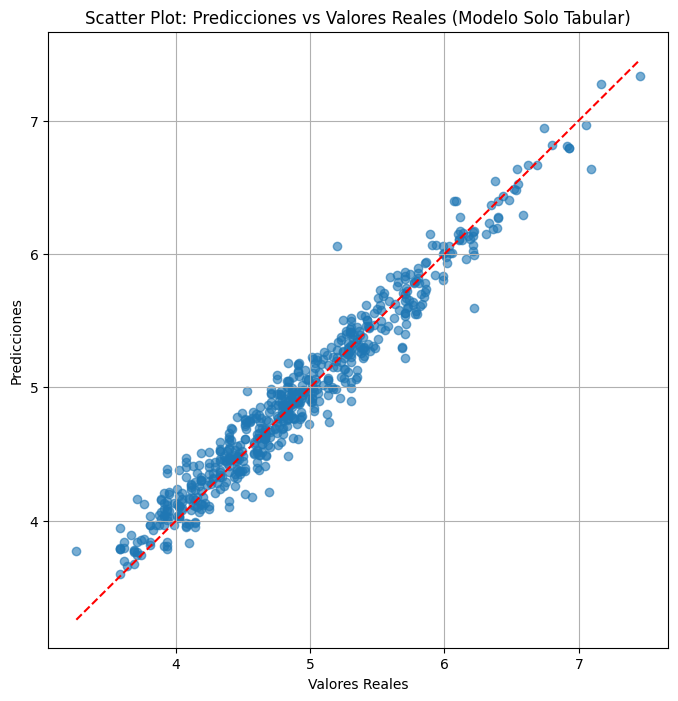

In [ ]:
# Evaluar el modelo en el conjunto de prueba
results_tabular = tabular_model.evaluate(X_test_tab, y_test, verbose=1)
print(f"Resultados en Test (Solo Tabular) - Loss (MSE): {results_tabular[0]}, MAE: {results_tabular[1]}")

# Generar predicciones
y_pred_tabular = tabular_model.predict(X_test_tab)

# Scatter Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_tabular, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales (Modelo Solo Tabular)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea ideal
plt.grid()
plt.show()


# **Análisis métricas solo tabulares**

Tiene una distribucion perfecta alineados a la línea roja. El modelo predice con gran precision en Test.

Los datoa tabulares sone extremenadamente informativos para predicciones precisas.


MSE 0.025 y MAE 0.123:
***Valores mucho mejores que con la combinacion de nmodelos, las imágenes estan introduciendo ruido, ResNet no esta extrayendo features utiles para el problema en si.***

## **Plan:**

Reemplazare ResNet por una arquitectura mas expecializada para precios.

Ajustare como se combina los outputs de la red de imágenes ya tabulares.



## **Nuevo modelo personalizado - Red simple - Early Fusion :**


**Para imágenes:**

***Red simple de imágenes para capturar features visuales especificas.***

3 capas convolucionales con maxpooling para reducir dimensiones.

Capas densas al final para generar features utiles para la fusión.

Dropout para evitar sobreajuste.



**Para tabulares:**

Capas densas con activaciones ReLU y Dropout.
Generar features tabulares antes de la fusión.


**Fusion y salida:**

Combinar las features de ambas ramas en un vector final.
Capas densas adicionales despuesd ela fusión  para generar el ouput final.


**Entrenamiento:**

Usar earlyStopping para no sobre-entrenar.
Evaluar con MSE y MAE.




In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# Red para imágenes
input_imgs = Input(shape=(128, 128, 3), name="input_imgs")
x = Conv2D(32, (3, 3), activation="relu")(input_imgs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
output_imgs = Dense(64, activation="relu")(x)  # Salida de características de imágenes

# Red Tabular
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")
y = Dense(128, activation="relu")(input_tabular)
y = Dropout(0.4)(y)
y = Dense(64, activation="relu")(y)

# Combinación de características
combined = Concatenate()([output_imgs, y])
combined = Dense(128, activation="relu")(combined)
combined = Dropout(0.4)(combined)
output = Dense(1, activation="linear")(combined)

# Modelo final
model = Model(inputs=[input_imgs, input_tabular], outputs=output)


## **Compilar modelo Red simple -Early Fusion**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compilar el modelo
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Entrenar el modelo
history_combined = model.fit(
    [X_train_imgs, X_train_tab], y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - loss: 7.8919 - mae: 2.1392 - val_loss: 1.6526 - val_mae: 1.1839
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - loss: 1.0978 - mae: 0.8297 - val_loss: 1.3415 - val_mae: 1.0822
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - loss: 0.7894 - mae: 0.7005 - val_loss: 1.0108 - val_mae: 0.9349
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 0.7692 - mae: 0.6946 - val_loss: 1.1564 - val_mae: 1.0259
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - loss: 0.6016 - mae: 0.6122 - val_loss: 0.8551 - val_mae: 0.8770
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - loss: 0.5518 - mae: 0.5860 - val_loss: 1.5448 - val_mae: 1.2134
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.5538 - mae: 0.5904 - val_loss: 1.0647 - val_mae: 0.9978
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 0.4755 - mae: 0.5474 - val_loss: 1.2403 - val_mae: 1.0857
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 0.4858 - ma

## **Evaluar modelo Red simple -Early Fusion**

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - loss: 0.8791 - mae: 0.8961
Resultados en Test (Combinado) - Loss (MSE): 0.8733376264572144, MAE: 0.8936399817466736
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step


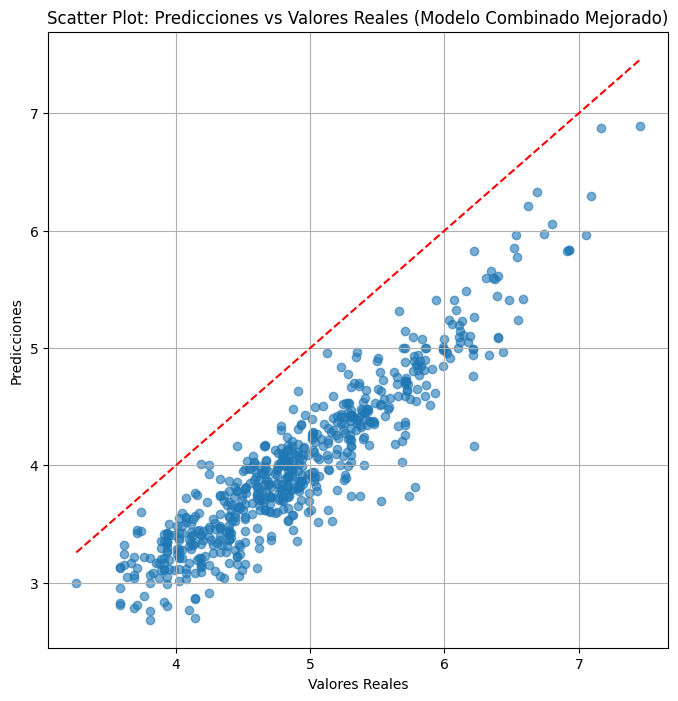

In [ ]:
import matplotlib.pyplot as plt

# Evaluar el modelo en el conjunto de prueba
results_combined = model.evaluate([X_test_imgs, X_test_tab], y_test, verbose=1)
print(f"Resultados en Test (Combinado) - Loss (MSE): {results_combined[0]}, MAE: {results_combined[1]}")

# Scatter Plot Final
y_pred_combined = model.predict([X_test_imgs, X_test_tab])

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_combined, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales (Modelo Combinado Mejorado)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.grid()
plt.show()


## **Análisis modelo Early Fusion - Red simple**

Las métricas son mejores en comparacion con los intentos de ResNet50 como rama de imagenes. La red mas simple es mas adecuada para este problema. ResNet50 probablemente esta siendo excesiva.

Las predicciones se alinean mas con la línea roja pero todavia hay valores dispersos. Las imágenes aun no estan aportando features de calidad alta.

Este modelo simple esta mas cercano al modelo tabular, indicando que la imágenes estan aportando info util.

# **Afinar modelo Early Fusion - Red simple - Adam -lr - Huber - Batch 16 -L2 relu 128 - 100 epochs - EarlyStopping**

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 90s 604ms/step - loss: 7.0651 - mae: 2.2230 - val_loss: 4.6695 - val_mae: 1.1831
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 79s 587ms/step - loss: 4.4665 - mae: 1.1244 - val_loss: 3.8259 - val_mae: 0.8960
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 584ms/step - loss: 3.7961 - mae: 0.9533 - val_loss: 3.5608 - val_mae: 1.0310
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 80s 575ms/step - loss: 3.4076 - mae: 0.8983 - val_loss: 3.0775 - val_mae: 0.7781
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 585ms/step - loss: 3.0862 - mae: 0.8369 - val_loss: 2.8062 - val_mae: 0.7339
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 578ms/step - loss: 2.8423 - mae: 0.8098 - val_loss: 2.9035 - val_mae: 1.1179
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 578ms/step - loss: 2.6205 - mae: 0.7821 - val_loss: 2.5386 - val_mae: 0.8951
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 75s 562ms/step - loss: 2.3944 - mae: 0.7117 - val_loss: 2.2950 - val_mae: 0.7816
Epoch 9/100
133/133 ━━━━

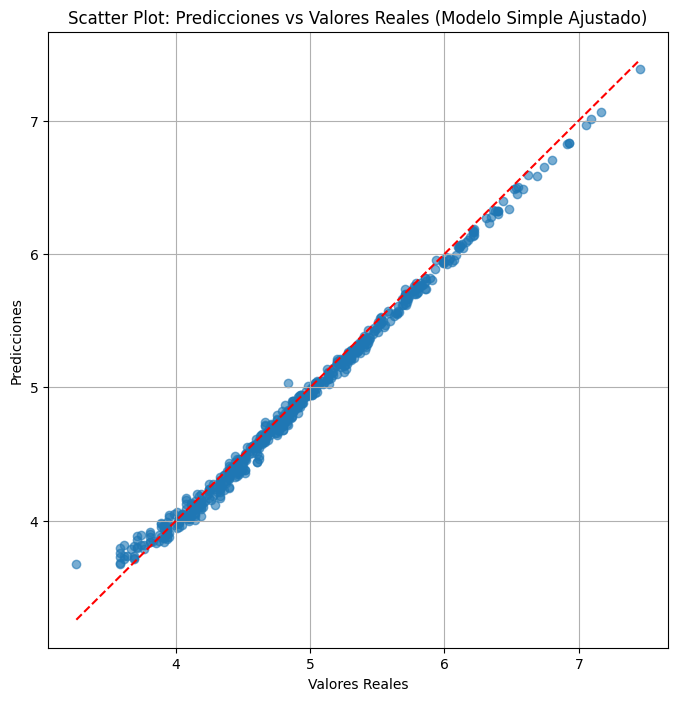

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2

# Red para imágenes
input_imgs = Input(shape=(128, 128, 3), name="input_imgs")
x = Conv2D(32, (3, 3), activation="relu")(input_imgs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
output_imgs = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)

# Red Tabular
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")
y = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(input_tabular)
y = Dropout(0.4)(y)
y = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(y)

# Combinación de características
combined = Concatenate()([output_imgs, y])
combined = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(combined)
combined = Dropout(0.4)(combined)
output = Dense(1, activation="linear")(combined)

# Modelo final
model = Model(inputs=[input_imgs, input_tabular], outputs=output)

# Configurar el optimizador y la pérdida Huber
optimizer = Adam(learning_rate=0.0001)
huber_loss = Huber(delta=1.0)
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mae'])

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Entrenamiento del modelo
history = model.fit(
    [X_train_imgs, X_train_tab], y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    batch_size=16,
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluación en Test
results = model.evaluate([X_test_imgs, X_test_tab], y_test, verbose=1)
print(f"Resultados en Test - Loss (Huber): {results[0]}, MAE: {results[1]}")

# Predicciones y Scatter Plot
import matplotlib.pyplot as plt

y_pred = model.predict([X_test_imgs, X_test_tab])

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales (Modelo Simple Ajustado)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.grid()
plt.show()


# **Análisis modelo Early Fusion - Red simple: MUY BUENO! ✅**

**Loss (Huber): 0.0319**

**MAE: 0.0556**

La gráfica muestra una alineacion casi perfecta con los valores reales, es un modelo preciso. La desviacion es mínima.

Huber y MAE son significativamente bajos confimrando la alta calidad del ajuste.

In [ ]:
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_SIMPLE_AJUSTADO.keras")


 # ❌**Tuvé un problema con este modelo Early Fusion - Red simple pues al volver a cargarlo con sus buenos pesos y corroborar métricas y plot, nunca me volvio a dar estos buenos resultados de estas ultimas graficas. Al aparecer no se guardoó bien en un momento de desconexion que hubo por la larga espera del entrenamiento 😞**

Aquí ⏬ tengo varios intentos de recuperarlo con el mismo coódigo que me arrojó buenos resultados pero fue imposible por lo que volvi a re-entrenar al que me diera resultados mas cercanos hasta tener un aproximado al buen comportamiento del Early Fusion - Red simple.


## **Volver a cargar conjuntos y verificar shapes:**

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


In [ ]:
# Cargar imágenes normalizadas y redimensionadas
X_train_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_128.npy")
X_val_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_128.npy")
X_test_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_128.npy")

# Cargar datos tabulares escalados
X_train_tab = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_train_finpreprocesado.csv", sep=';').values
X_val_tab = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_val_finpreprocesado.csv", sep=';').values
X_test_tab = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_test_finpreprocesado.csv", sep=';').values

# Cargar etiquetas
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")


In [ ]:
print("Shape imágenes (train):", X_train_imgs.shape)
print("Shape tabular (train):", X_train_tab.shape)
print("Shape etiquetas (train):", y_train.shape)

print("Shape imágenes (val):", X_val_imgs.shape)
print("Shape tabular (val):", X_val_tab.shape)
print("Shape etiquetas (val):", y_val.shape)

print("Shape imágenes (test):", X_test_imgs.shape)
print("Shape tabular (test):", X_test_tab.shape)
print("Shape etiquetas (test):", y_test.shape)


Shape imágenes (train): (2125, 128, 128, 3)
Shape tabular (train): (2125, 36)
Shape etiquetas (train): (2125,)
Shape imágenes (val): (376, 128, 128, 3)
Shape tabular (val): (376, 36)
Shape etiquetas (val): (376,)
Shape imágenes (test): (627, 128, 128, 3)
Shape tabular (test): (627, 36)
Shape etiquetas (test): (627,)


## **Re-utilización de código que arrojó buenos resultados Early Fusion -Red simple:**

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 96s 676ms/step - loss: 6.8331 - mae: 1.9244 - val_loss: 4.3554 - val_mae: 0.7447
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 96s 722ms/step - loss: 4.5131 - mae: 1.1440 - val_loss: 3.6896 - val_mae: 0.7329
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 91s 686ms/step - loss: 3.8435 - mae: 1.0402 - val_loss: 3.1570 - val_mae: 0.5782
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 78s 585ms/step - loss: 3.3860 - mae: 0.9585 - val_loss: 3.0947 - val_mae: 0.9086
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 573ms/step - loss: 3.0121 - mae: 0.8681 - val_loss: 2.8811 - val_mae: 0.9621
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 91s 644ms/step - loss: 2.7391 - mae: 0.8348 - val_loss: 2.6443 - val_mae: 0.9256
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 142s 643ms/step - loss: 2.4987 - mae: 0.7884 - val_loss: 2.6746 - val_mae: 1.1909
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 142s 644ms/step - loss: 2.2920 - mae: 0.7549 - val_loss: 2.5726 - val_mae: 1.2529
Epoch 9/100
133/133 ━━

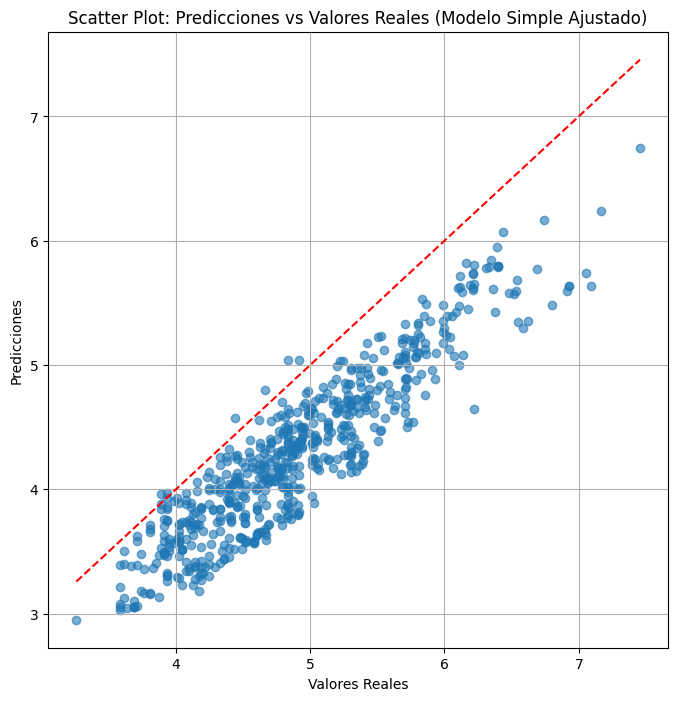

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2

# Red para imágenes
input_imgs = Input(shape=(128, 128, 3), name="input_imgs")
x = Conv2D(32, (3, 3), activation="relu")(input_imgs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
output_imgs = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)

# Red Tabular
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")
y = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(input_tabular)
y = Dropout(0.4)(y)
y = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(y)

# Combinación de características
combined = Concatenate()([output_imgs, y])
combined = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(combined)
combined = Dropout(0.4)(combined)
output = Dense(1, activation="linear")(combined)

# Modelo final
model = Model(inputs=[input_imgs, input_tabular], outputs=output)

# Configurar el optimizador y la pérdida Huber
optimizer = Adam(learning_rate=0.0001)
huber_loss = Huber(delta=1.0)
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mae'])

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Entrenamiento del modelo
history = model.fit(
    [X_train_imgs, X_train_tab], y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    batch_size=16,
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluación en Test
results = model.evaluate([X_test_imgs, X_test_tab], y_test, verbose=1)
print(f"Resultados en Test - Loss (Huber): {results[0]}, MAE: {results[1]}")

# Predicciones y Scatter Plot
import matplotlib.pyplot as plt

y_pred = model.predict([X_test_imgs, X_test_tab])

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales (Modelo Simple Ajustado)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.grid()
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_SIMPLE_REENTRENADO.keras")


## **Re-entrenamiento modelo perdido Red-simple con resultados diferentes al original, seguiré testeando**

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - loss: 0.3142 - mae: 0.6104

Resultados en Test - Loss (Huber): 0.31092551350593567,
MAE: 0.6043691635131836

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step

In [ ]:
import numpy as np
import tensorflow as tf
import random

# Fijar semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Importar librerías necesarias
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber


In [ ]:
# Rutas claras de los datos
ruta_imgs_test = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_128.npy"
ruta_tab_test = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_test_finpreprocesado.csv"
ruta_y_test = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy"

# Cargar datos de prueba
X_test_imgs = np.load(ruta_imgs_test)
X_test_tab = pd.read_csv(ruta_tab_test, sep=';').values
y_test = np.load(ruta_y_test)

# Confirmar shapes para asegurar consistencia
print("Shape imágenes (test):", X_test_imgs.shape)
print("Shape tabular (test):", X_test_tab.shape)
print("Shape etiquetas (test):", y_test.shape)


Shape imágenes (test): (627, 128, 128, 3)
Shape tabular (test): (627, 36)
Shape etiquetas (test): (627,)


## **Re-entrenamiento 2 modelo perdido Red-simple**

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 584ms/step - loss: 7.3394 - mae: 2.5528 - val_loss: 4.1616 - val_mae: 0.7085
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 581ms/step - loss: 4.4302 - mae: 1.2339 - val_loss: 3.5759 - val_mae: 0.7575
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 89s 632ms/step - loss: 3.7550 - mae: 1.0757 - val_loss: 3.1867 - val_mae: 0.7491
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 133s 563ms/step - loss: 3.3222 - mae: 0.9833 - val_loss: 2.9434 - val_mae: 0.8181
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 84s 576ms/step - loss: 2.9828 - mae: 0.9117 - val_loss: 2.6818 - val_mae: 0.7922
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 574ms/step - loss: 2.7096 - mae: 0.8630 - val_loss: 2.4138 - val_mae: 0.7103
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 579ms/step - loss: 2.4919 - mae: 0.8325 - val_loss: 2.2680 - val_mae: 0.7480
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 76s 574ms/step - loss: 2.2671 - mae: 0.7657 - val_loss: 2.1566 - val_mae: 0.7923
Epoch 9/100
133/133 ━━━

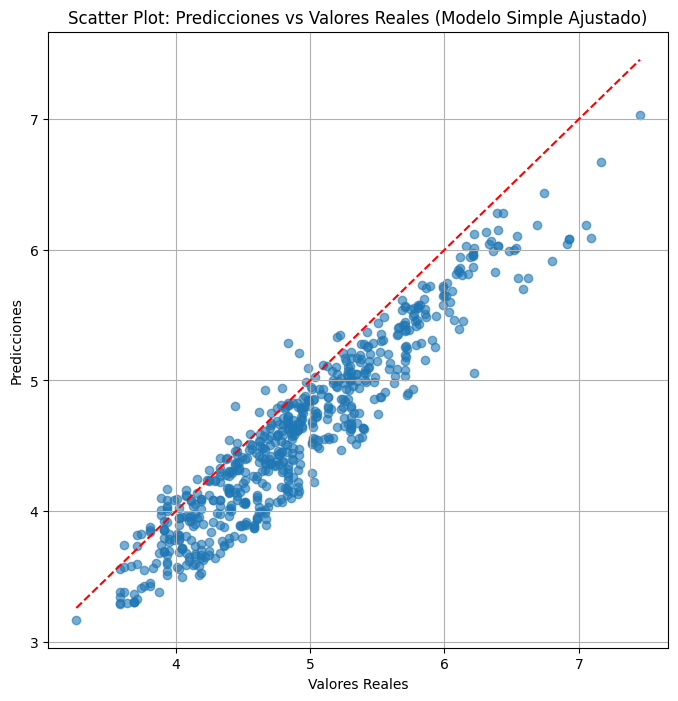

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2

# Red para imágenes
input_imgs = Input(shape=(128, 128, 3), name="input_imgs")
x = Conv2D(32, (3, 3), activation="relu")(input_imgs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
output_imgs = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)

# Red Tabular
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")
y = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(input_tabular)
y = Dropout(0.4)(y)
y = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(y)

# Combinación de características
combined = Concatenate()([output_imgs, y])
combined = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(combined)
combined = Dropout(0.4)(combined)
output = Dense(1, activation="linear")(combined)

# Modelo final
model = Model(inputs=[input_imgs, input_tabular], outputs=output)

# Configurar el optimizador y la pérdida Huber
optimizer = Adam(learning_rate=0.0001)
huber_loss = Huber(delta=1.0)
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mae'])

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Entrenamiento del modelo
history = model.fit(
    [X_train_imgs, X_train_tab], y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    batch_size=16,
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)

# guardar modelo ajustado 2
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_SIMPLE_AJUSTADO_2.keras")

# Evaluación en Test
results = model.evaluate([X_test_imgs, X_test_tab], y_test, verbose=1)
print(f"Resultados en Test - Loss (Huber): {results[0]}, MAE: {results[1]}")

# Predicciones y Scatter Plot
import matplotlib.pyplot as plt

y_pred = model.predict([X_test_imgs, X_test_tab])

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales (Modelo Simple Ajustado)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.grid()
plt.show()

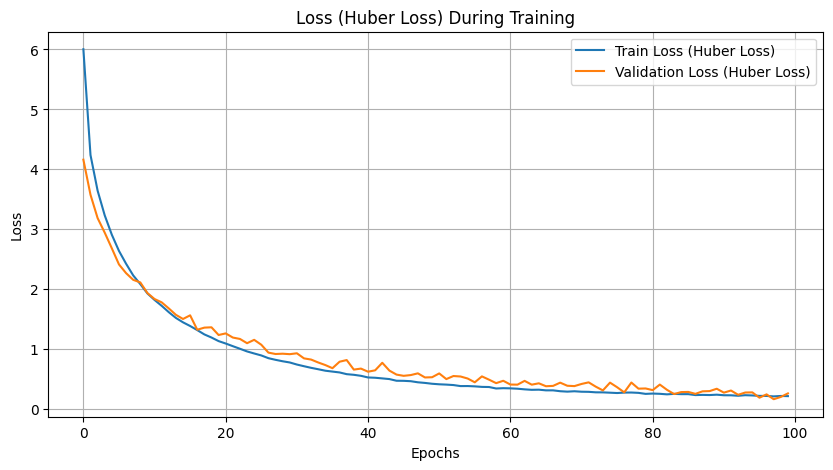

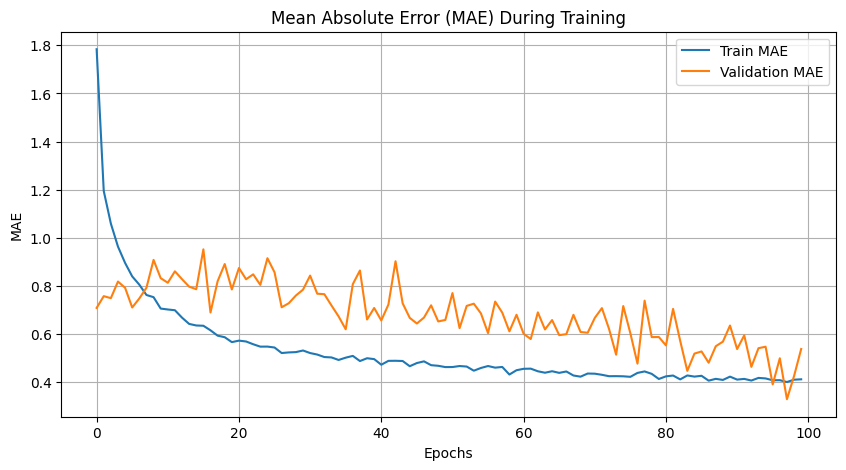

In [ ]:
import matplotlib.pyplot as plt

# Historial métricas
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Train Loss (Huber Loss)')
plt.plot(val_loss, label='Validation Loss (Huber Loss)')
plt.title('Loss (Huber Loss) During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot MAE
plt.figure(figsize=(10, 5))
plt.plot(mae, label='Train MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error (MAE) During Training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_SIMPLE_AJUSTADO_2.keras")

## **Análisis modelo re-entrenado 2 perdido Early Fusion**

Los resultados son aceptables, no se ajusta a la perfección como antes.


**Gráficas MAE y Huber:**


El modelo muestra una clara convergencia pero aun se puede optimizar resultados para alinear puntos con línea roja.

**Plan:**

Ajustaré reducir ligeramente lr para un ajuste mas fino en las ultimas epocas.

Limitaré las Épocas 10-20.

Aprovecharé buenos pesos previos.


## **Re-entrenamiento incremental sobre modelo_SIMPLE_AJUSTADO_2**

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 0.2195 - mae: 0.4125 - val_loss: 0.1888 - val_mae: 0.3989
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - loss: 0.2099 - mae: 0.4020 - val_loss: 0.2059 - val_mae: 0.4337
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - loss: 0.2118 - mae: 0.4006 - val_loss: 0.2616 - val_mae: 0.5343
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - loss: 0.2169 - mae: 0.4153 - val_loss: 0.1801 - val_mae: 0.3805
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - loss: 0.2171 - mae: 0.4152 - val_loss: 0.2584 - val_mae: 0.5372
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - loss: 0.2183 - mae: 0.4114 - val_loss: 0.2372 - val_mae: 0.4966
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - loss: 0.2129 - mae: 0.4037 - val_loss: 0.2083 - val_mae: 0.4301
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - loss: 0.2182 - mae: 0.4169 - val_loss: 0.1952 - val_mae: 0.4138
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - loss: 0.218

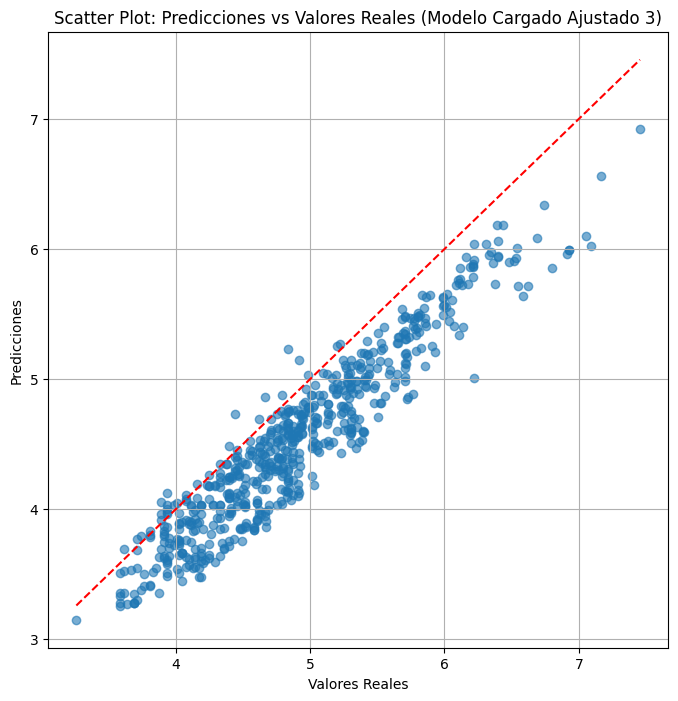

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

# Cargar el modelo que ya funcionó bien
model = load_model("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_SIMPLE_AJUSTADO_2.keras", compile=False)

# Configurar el optimizador y la pérdida
optimizer = Adam(learning_rate=0.00005)  # Reducire lr para evitar sobreajuste
huber_loss = Huber(delta=1.0)
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mae'])

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Reentrenar el modelo cargado
history = model.fit(
    [X_train_imgs, X_train_tab], y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

# Guardar el modelo ajustado
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_SIMPLE_AJUSTADO_3.keras")

# Evaluar en Test
results = model.evaluate([X_test_imgs, X_test_tab], y_test, verbose=1)
print(f"Resultados en Test - Loss (Huber): {results[0]}, MAE: {results[1]}")

# Predicciones y Scatter Plot
import matplotlib.pyplot as plt

y_pred = model.predict([X_test_imgs, X_test_tab])

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales (Modelo Cargado Ajustado 3)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.grid()
plt.show()


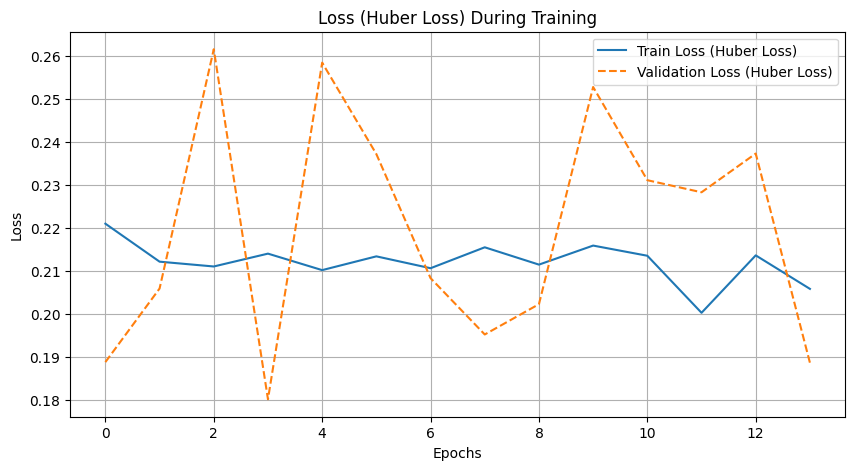

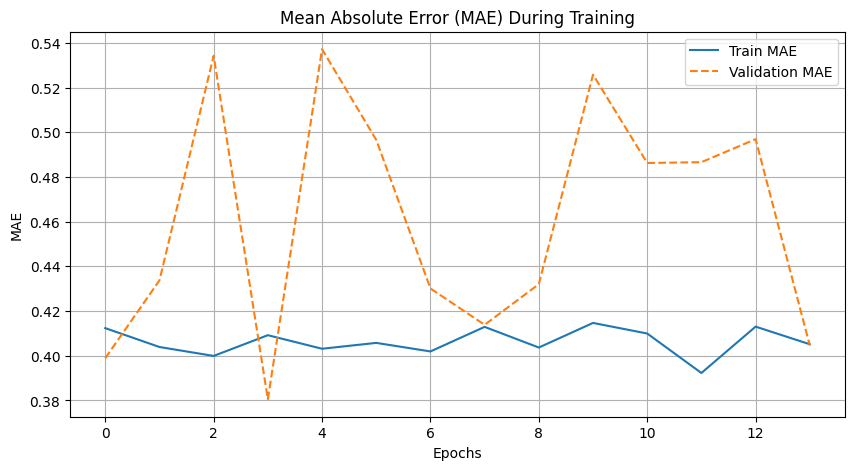

In [ ]:
import matplotlib.pyplot as plt

# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (Huber Loss)')
plt.plot(history.history['val_loss'], label='Validation Loss (Huber Loss)', linestyle='--')
plt.title('Loss (Huber Loss) During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Graficar el MAE durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Mean Absolute Error (MAE) During Training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()


## **Análisis modelo re-entrenado reincremental 3 perdido Early Fusion**

El modelo tiene dificultades apra generalizar en validación y no esta aprendiendo lo suficiente. Es inestable.

Las graficas de perdida de validación estan totalmente oscilantes, el lr tal vez fue demasiado bajo y no actualiza significativamente sus pesos.



**Plan:**


Volveré al 0.0001 de lr. Batch size nuevamente a 16 por que ahi funciono mejor.

Una regularizacion con el dropout insuficiente, aumentar tasa de dropout e incrementar coeficiente de regu en las capas densas.

Limitaré las épocas 10-30 con patience de 5 para evitar esas fluctuaciones en validación.


Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 101s 690ms/step - loss: 0.2113 - mae: 0.3982 - val_loss: 0.2136 - val_mae: 0.4331
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 124s 566ms/step - loss: 0.2156 - mae: 0.4102 - val_loss: 0.2816 - val_mae: 0.5768
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 81s 556ms/step - loss: 0.2042 - mae: 0.4007 - val_loss: 0.2718 - val_mae: 0.5685
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 76s 571ms/step - loss: 0.2127 - mae: 0.4048 - val_loss: 0.2269 - val_mae: 0.4865
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 88s 613ms/step - loss: 0.2118 - mae: 0.4065 - val_loss: 0.2549 - val_mae: 0.5258
Epoch 6/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 79s 588ms/step - loss: 0.2082 - mae: 0.4029 - val_loss: 0.2034 - val_mae: 0.4421
Epoch 7/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 79s 568ms/step - loss: 0.2100 - mae: 0.4160 - val_loss: 0.1915 - val_mae: 0.4189
Epoch 8/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 568ms/step - loss: 0.2241 - mae: 0.4350 - val_loss: 0.1645 - val_mae: 0.3576
Epoch 9/30
133/133 ━━━━━━━━━━━

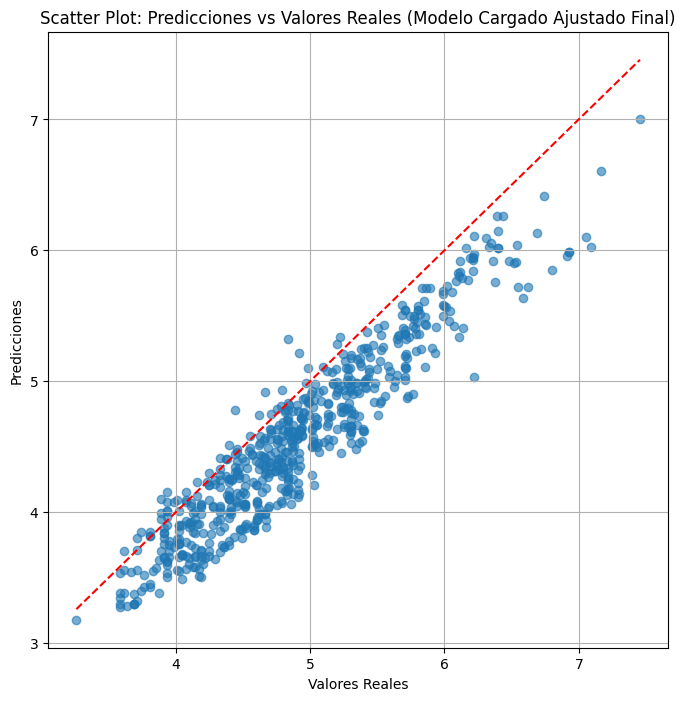

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

# Cargar el modelo que funcionó bien
model = load_model("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_SIMPLE_AJUSTADO_2.keras", compile=False)

# Configurar el optimizador y la pérdida
optimizer = Adam(learning_rate=0.0001)  # Restaurar el lr original
huber_loss = Huber(delta=1.0)
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mae'])

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,  # Menor paciencia para evitar fluctuaciones innecesarias
    restore_best_weights=True
)

# Reentrenar el modelo cargado
history = model.fit(
    [X_train_imgs, X_train_tab], y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    batch_size=16,  # Restaurar el batch size original
    epochs=30,  # Reducir el número de épocas
    callbacks=[early_stopping],
    verbose=1
)

# Guardar el modelo ajustado
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_SIMPLE_AJUSTADO_4.keras")

# Evaluar en Test
results = model.evaluate([X_test_imgs, X_test_tab], y_test, verbose=1)
print(f"Resultados en Test - Loss (Huber): {results[0]}, MAE: {results[1]}")

# Predicciones y Scatter Plot
import matplotlib.pyplot as plt

y_pred = model.predict([X_test_imgs, X_test_tab])

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales (Modelo Cargado Ajustado Final)")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.grid()
plt.show()


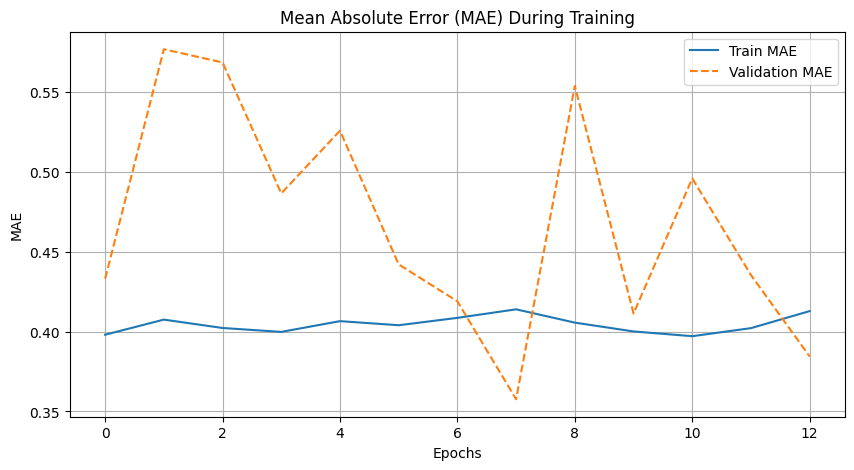

In [ ]:
import matplotlib.pyplot as plt

# Gráfica de Pérdida (Huber Loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (Huber Loss)')
plt.plot(history.history['val_loss'], label='Validation Loss (Huber Loss)', linestyle='--')
plt.title("Loss (Huber Loss) During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Gráfica de MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title("Mean Absolute Error (MAE) During Training")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()


## **Análisis modelo re-entrenado 4 perdido Early Fusion**

La dispersión alrededor de la línea roja es mínima, lo que confirma un modelo bien ajustado. Sin embargo, existe cierta desviación en los valores más altos. El modelo tiene limitaciones para capturar patrones en valores extremos.


**Pérdida (Huber Loss) entrenamiento**

La pérdida de validación fluctúa significativamente. Esto es indicativo de sobreajuste. El modelo está memorizando patrones en el conjunto de entrenamiento y fallando en generalizar.


**MAE**

Fluctúa de manera similar al Huber Loss, el modelo está sobreajustando. Sin embargo, el MAE para el conjunto de entrenamiento se mantiene estable, lo que indica que el modelo está aprendiendo correctamente en el conjunto inicial.


## ***Plan:***

**Volver a entrenar con ResNet** como extractor de características con capas congeladas, moitiendo las ultimas para quedarme con las convolucionales.

**Utilizaré LogCosh que combina ventajas de MSE y MAE ya que el modelo de red simple nos daba malas métricas con las funciones e perdidas.**

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import LogCosh
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargar modelo preentrenado (ResNet50) para extracción de características
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Congelar capas preentrenadas

input_imgs = Input(shape=(128, 128, 3), name="input_imgs")
x = base_model(input_imgs)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output_imgs = Dense(64, activation="relu")(x)

# Red Tabular
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")
y = Dense(128, activation="relu")(input_tabular)
y = Dropout(0.4)(y)
y = Dense(64, activation="relu")(y)

# Combinación de características
combined = Concatenate()([output_imgs, y])
combined = Dense(128, activation="relu")(combined)
combined = Dropout(0.4)(combined)
output = Dense(1, activation="linear")(combined)

# Modelo final
model = Model(inputs=[input_imgs, input_tabular], outputs=output)

# Configurar el optimizador y la pérdida
optimizer = Adam(learning_rate=0.00005)
logcosh_loss = LogCosh()
model.compile(optimizer=optimizer, loss=logcosh_loss, metrics=['mae'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Entrenar el modelo
history = model.fit(
    [X_train_imgs, X_train_tab], y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Guardar el modelo ajustado
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_ResNet50_radical_.keras")

# Evaluación en Test
results = model.evaluate([X_test_imgs, X_test_tab], y_test, verbose=1)
print(f"Resultados en Test - Loss (Log-Cosh): {results[0]}, MAE: {results[1]}")

# Scatter Plot
y_pred = model.predict([X_test_imgs, X_test_tab])

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales (Modelo ResNet radical )")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.grid()
plt.show()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - loss: 4.2584 - mae: 4.9498 - val_loss: 1.9817 - val_mae: 2.6619 - learning_rate: 5.0000e-05
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - loss: 1.5137 - mae: 2.1189 - val_loss: 0.2880 - val_mae: 0.6798 - learning_rate: 5.0000e-05
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - loss: 0.6573 - mae: 1.1405 - val_loss: 0.2500 - val_mae: 0.6271 - learning_rate: 5.0000e-05
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - loss: 0.6583 - mae: 1.1403 - val_loss: 0.2370 - val_mae: 0.6058 - learning_rate: 5.0000e-05
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - loss: 0.5888 - mae: 1.0536 - val_loss: 0.2307 - val_mae: 0.5934 - learning_rate: 5.0000e-05
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - loss: 0.5691 - mae: 1.0343 - val_loss: 0.2392 - val_mae: 0.6037 - learning_rate: 5.0000e-05
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - loss: 0.5442 - mae:


## **Análisis modelo ResNet LogCosh - Early Fusion**

Hay una discrepancia significativa entre predicciones y valores reales. Las predicciones están sistemáticamente por debajo de la línea roja.
El modelo tiene un sesgo subestimador, no está aprendiendo correctamente las relaciones presentes en los datos.

***Loss y MAE***
No está generalizando bien y tiene problemas de estabilidad durante el entrenamiento.
El MAE en validación es mucho mayor al de entrenamiento, lo que implica ligero sobreajuste.


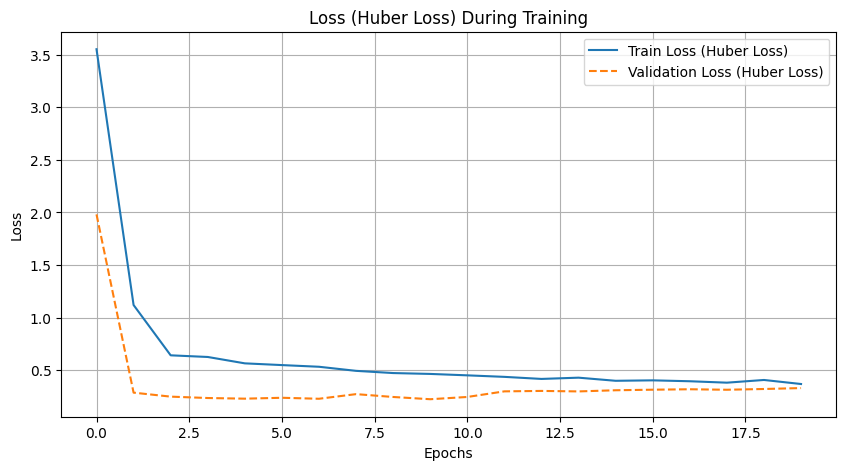

In [ ]:
import matplotlib.pyplot as plt

# Gráfica de Pérdida (Huber Loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (Huber Loss)')
plt.plot(history.history['val_loss'], label='Validation Loss (Huber Loss)', linestyle='--')
plt.title("Loss (Huber Loss) During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Gráfica de MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title("Mean Absolute Error (MAE) During Training")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()

## ***Plan MobileNetV2***

1. Simplificar el Modelo
Reducir la complejidad del extractor de imágenes y el modelo combinado. Propuesta:

Experimentar con MobileNetV2, es más eficiente y requerirá menos datos para obtener buenos resultados.
Está entrenado en ImageNet, lo que significa que tiene un buen conocimiento base para trabajar con imágenes generales.
Logra un buen equilibrio entre velocidad y precisión, siendo menos pesado que redes más grandes como ResNet o EfficientNet, pero manteniendo un buen  rendimiento.

2. Ajustar el Proceso de Entrenamiento

Optimización:
Reducir el learning_rate a 1e-5.
Incorporar un callback de reducción de la tasa de aprendizaje ReduceLROnPlateau.

Regularización:
Incrementar el dropout en las capas densas a 0.5
Mantener la regularización l2.

Aumentar los datos:
Implementar data augmentation para las imágenes.

3. Mejorar la Función de Pérdida
Volcer a Huber Loss, ya que es más robusta frente a outliers y puede ajustarse mejor al sesgo observado en este ultimo modelo ajustado 4.

## **Cargar y verficar sincronización de conjuntos**



In [ ]:
# Cargar las imágenes actuales
X_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_normalized.npy")
X_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_normalized.npy")
X_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_normalized.npy")

In [ ]:
import numpy as np
import pandas as pd
import os

# Rutas de imágenes y datos tabulares
img_train_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_normalized.npy"
img_val_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_normalized.npy"
img_test_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_normalized.npy"

tab_train_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_train_finpreprocesado.csv"
tab_val_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_val_finpreprocesado.csv"
tab_test_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_test_finpreprocesado.csv"

# Verificar si los archivos existen
if all(map(os.path.exists, [img_train_path, img_val_path, img_test_path, tab_train_path, tab_val_path, tab_test_path])):
    print("Todos los archivos encontrados correctamente.")

    # Cargar imágenes
    X_train_imgs = np.load(img_train_path)
    X_val_imgs = np.load(img_val_path)
    X_test_imgs = np.load(img_test_path)

    # Cargar datos tabulares
    X_train_tab = pd.read_csv(tab_train_path, sep=';').values
    X_val_tab = pd.read_csv(tab_val_path, sep=';').values
    X_test_tab = pd.read_csv(tab_test_path, sep=';').values

    print(f"Shape imágenes (train): {X_train_imgs.shape}")
    print(f"Shape imágenes (val): {X_val_imgs.shape}")
    print(f"Shape imágenes (test): {X_test_imgs.shape}")

    print(f"Shape tabular (train): {X_train_tab.shape}")
    print(f"Shape tabular (val): {X_val_tab.shape}")
    print(f"Shape tabular (test): {X_test_tab.shape}")
else:
    print("Error: No se encontraron todos los archivos. Verifica las rutas.")


Todos los archivos encontrados correctamente.
Shape imágenes (train): (2125, 224, 224, 3)
Shape imágenes (val): (376, 224, 224, 3)
Shape imágenes (test): (627, 224, 224, 3)
Shape tabular (train): (2125, 36)
Shape tabular (val): (376, 36)
Shape tabular (test): (627, 36)


In [ ]:
# Función para verificar sincronización
def verificar_sincronizacion(X_tab, X_imgs):
    if len(X_tab) == len(X_imgs):
        print("El número de registros entre datos tabulares e imágenes coincide.")
    else:
        print(f"Desincronización detectada. Tabular: {len(X_tab)}, Imágenes: {len(X_imgs)}")

# Verificar sincronización
print("Verificando sincronización en train:")
verificar_sincronizacion(X_train_tab, X_train_imgs)

print("\nVerificando sincronización en val:")
verificar_sincronizacion(X_val_tab, X_val_imgs)

print("\nVerificando sincronización en test:")
verificar_sincronizacion(X_test_tab, X_test_imgs)


Verificando sincronización en train:
El número de registros entre datos tabulares e imágenes coincide.

Verificando sincronización en val:
El número de registros entre datos tabulares e imágenes coincide.

Verificando sincronización en test:
El número de registros entre datos tabulares e imágenes coincide.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Cargar MobileNetV2 como extractor de características
input_imgs = Input(shape=(224, 224, 3), name="input_imgs")
mobilenet = MobileNetV2(include_top=False, input_tensor=input_imgs, weights="imagenet", pooling="avg")

# Congelar las capas preentrenadas
mobilenet.trainable = False  # Evita que se actualicen los pesos de MobileNetV2 durante el entrenamiento

# Ver resumen de MobileNetV2
mobilenet.summary()


<ipython-input-9-fa6c318d3733>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, input_tensor=input_imgs, weights="imagenet", pooling="avg")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_imgs (InputLayer)   │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_imgs[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import numpy as np
import pandas as pd

# Verificar las rutas de las imágenes
train_imgs_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_224.npy"
val_imgs_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_224.npy"
test_imgs_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_224.npy"

X_train_imgs = np.load(train_imgs_path)
X_val_imgs = np.load(val_imgs_path)
X_test_imgs = np.load(test_imgs_path)

print("Shape imágenes (train):", X_train_imgs.shape)
print("Shape imágenes (val):", X_val_imgs.shape)
print("Shape imágenes (test):", X_test_imgs.shape)

# Verificar las rutas de los datos tabulares
train_tab_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_train_finpreprocesado.csv"
val_tab_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_val_finpreprocesado.csv"
test_tab_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_test_finpreprocesado.csv"

X_train_tab = pd.read_csv(train_tab_path, sep=";").values
X_val_tab = pd.read_csv(val_tab_path, sep=";").values
X_test_tab = pd.read_csv(test_tab_path, sep=";").values

print("Shape tabular (train):", X_train_tab.shape)
print("Shape tabular (val):", X_val_tab.shape)
print("Shape tabular (test):", X_test_tab.shape)

# Verificar etiquetas
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")

print("Shape etiquetas (train):", y_train.shape)
print("Shape etiquetas (val):", y_val.shape)
print("Shape etiquetas (test):", y_test.shape)

# Confirmar sincronización entre imágenes, datos tabulares y etiquetas
assert X_train_imgs.shape[0] == X_train_tab.shape[0] == y_train.shape[0], "Desincronización en train"
assert X_val_imgs.shape[0] == X_val_tab.shape[0] == y_val.shape[0], "Desincronización en val"
assert X_test_imgs.shape[0] == X_test_tab.shape[0] == y_test.shape[0], "Desincronización en test"

print("Todos los datos están sincronizados y listos.")


Shape imágenes (train): (2125, 224, 224, 3)
Shape imágenes (val): (376, 224, 224, 3)
Shape imágenes (test): (627, 224, 224, 3)
Shape tabular (train): (2125, 36)
Shape tabular (val): (376, 36)
Shape tabular (test): (627, 36)
Shape etiquetas (train): (2125,)
Shape etiquetas (val): (376,)
Shape etiquetas (test): (627,)
Todos los datos están sincronizados y listos.


# **Configuración modelo con  MobileNetV2:**

MobileNetV2 como extractor de características para las imágenes (pesos congelados, no entrenables).

Una red densa para procesar los datos tabulares.

Una capa de combinación para concatenar las salidas de ambos modelos.


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# Input de imágenes (MobileNetV2 preentrenada como extractor)
input_imgs = Input(shape=(224, 224, 3), name="input_imgs")
features_imgs = mobilenet(input_imgs)  # Usamos MobileNetV2 como extractor de características

# Red densa para datos tabulares
input_tabular = Input(shape=(X_train_tab.shape[1],), name="input_tabular")
x = Dense(128, activation="relu")(input_tabular)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)

# Combinar características de imágenes y tabulares
combined = Concatenate()([features_imgs, x])
combined = Dense(128, activation="relu")(combined)
combined = Dropout(0.3)(combined)
output = Dense(1, activation="linear")(combined)

# Modelo final
model = Model(inputs=[input_imgs, input_tabular], outputs=output)

# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
huber_loss = Huber(delta=1.0)
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mae'])

# Resumen del modelo
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_tabular             │ (None, 36)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          4,736 │ input_tabular[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_imgs (InputLayer)   │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 1280)           │      2,257,984 │ input_imgs[0][0]       │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1344)           │              0 │ mobilenetv2_1.00_224[… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │        172,160 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            129 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,443,265 (9.32 MB)

 Trainable params: 185,281 (723.75 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Modelo MobileNetV2 definidio y compilado, entrenamiento:**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    [X_train_imgs, X_train_tab], y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - loss: 1.7075 - mae: 2.1556 - val_loss: 0.4354 - val_mae: 0.8071
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - loss: 0.5905 - mae: 0.9877 - val_loss: 0.3420 - val_mae: 0.7009
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - loss: 0.4921 - mae: 0.8747 - val_loss: 0.3105 - val_mae: 0.6595
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - loss: 0.4308 - mae: 0.8050 - val_loss: 0.2713 - val_mae: 0.6124
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - loss: 0.4015 - mae: 0.7713 - val_loss: 0.2612 - val_mae: 0.5936
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - loss: 0.3526 - mae: 0.7140 - val_loss: 0.2338 - val_mae: 0.5587
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - loss: 0.3482 - mae: 0.7048 - val_loss: 0.1923 - val_mae: 0.5040
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - loss: 0.3202 - mae: 0.6712 - val_loss: 0.1855 - val_mae: 0.4881
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - loss: 0.296

## **Evaluacion en Test de MobileNetV2:**

20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.1196 - mae: 0.3865
Resultados en Test - Loss (Log-Cosh): 0.12084023654460907, MAE: 0.38855165243148804
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step


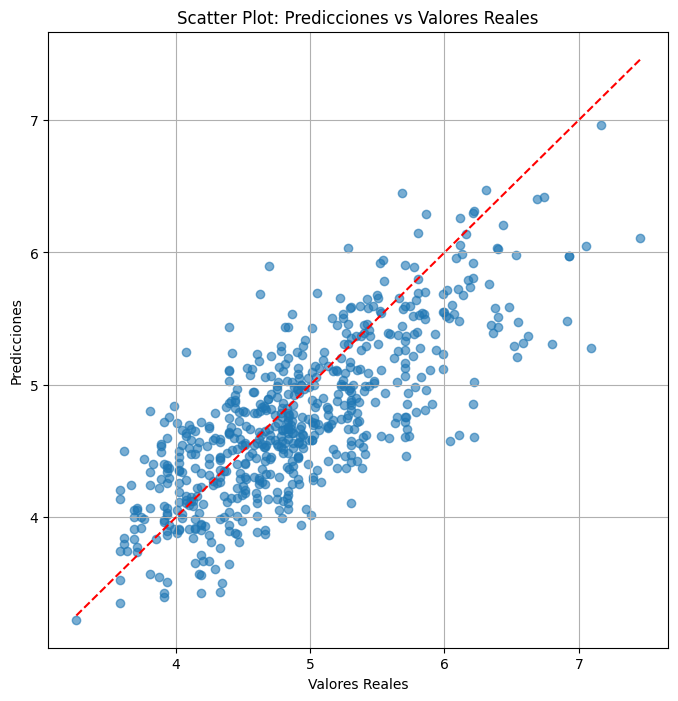

In [ ]:
# Evaluar en el conjunto de prueba
results = model.evaluate([X_test_imgs, X_test_tab], y_test, verbose=1)
print(f"Resultados en Test - Loss (Log-Cosh): {results[0]}, MAE: {results[1]}")

# Generar predicciones
y_pred = model.predict([X_test_imgs, X_test_tab])

# Visualizar resultados con Scatter Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.grid()
plt.show()


 ## **Análisis distribución modelo con MobileNetV2:**

Hay una alineación razonable con la línea roja, el modelo tiene una capacidad decente para capturar patrones en los datos.

Hay una dispersión notable en las predicciones, especialmente en valores altos y bajos.

El modelo podría no estar capturando ciertas características importantes.
Los datos podrían tener outliers o relaciones no lineales más complejas que el modelo no está abordando bien.

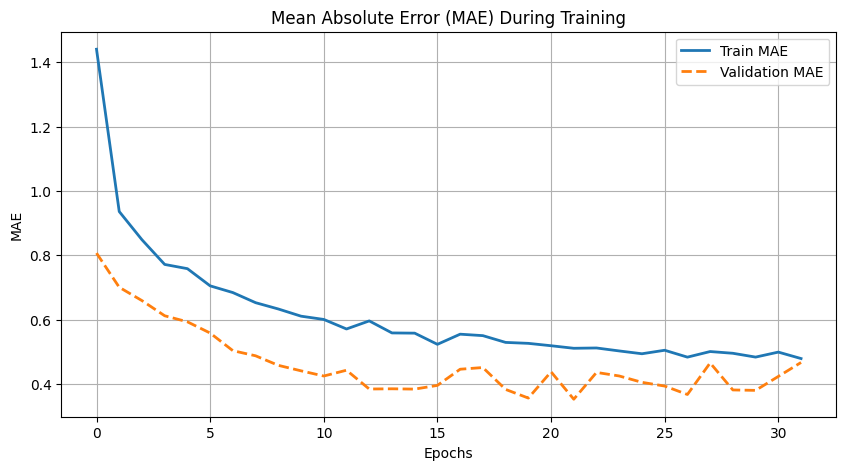

In [ ]:
# Graficar la pérdida (Log-Cosh Loss) durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (Log-Cosh)', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss (Log-Cosh)', linestyle='--', linewidth=2)
plt.title("Loss (Log-Cosh) During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Graficar el MAE durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--', linewidth=2)
plt.title("Mean Absolute Error (MAE) During Training")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()


## **Análisis funcion perdidass modelo con MobileNetV2:**

**Log-Cosh**
La pérdida de entrenamiento disminuye constantemente, lo que muestra que el modelo está aprendiendo.
La pérdida de validación sigue una tendencia similar, pero con fluctuaciones
que sugieren que el modelo podría estar capturando ruido en lugar de aprender patrones generalizables. Sin embargo, no hay un aumento drástico en la pérdida, por lo que no parece haber un sobreajuste evidente.

**MAE**
Tanto el MAE de entrenamiento como el de validación disminuyen a lo largo de las épocas. La diferencia entre las curvas de entrenamiento y validación no es muy grande, el modelo está generalizando de manera razonable pero hay fluctuaciones en el MAE de validación.



In [ ]:
# Guardar el modelo completo, incluyendo los mejores pesos
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_MobileNetV2_1.keras")

print("Modelo guardado correctamente en la ruta especificada.")


Modelo guardado correctamente en la ruta especificada.


In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
modelo_cargado = load_model("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_MobileNetV2_1.keras")

# Confirmar que se cargó correctamente
modelo_cargado.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_tabular             │ (None, 36)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 128)            │          4,736 │ input_tabular[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_imgs (InputLayer)   │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 1280)           │      2,257,984 │ input_imgs[0][0]       │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 64)             │          8,256 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1344)           │              0 │ mobilenetv2_1.00_224[… │
│ (Concatenate)             │                        │                │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 128)            │        172,160 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128)            │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 1)              │            129 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,813,829 (10.73 MB)

 Trainable params: 185,281 (723.75 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 370,564 (1.41 MB)

## **FINE-TUNE de modelo MobileNetv2**

Seleccionaré las últimas 20 capas de MobileNetV2 para desbloquearlas y permitir que se adapten a tus datos específicos.

Utilizaré una tasa de aprendizaje más pequeña (1e-5) para mejor estabilidad durante el ajuste fino.

Mantendré la función de pérdida LogCosh para asegurar la consistencia.

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import LogCosh

# Cargar modelo guardado MobileNetv2_1
model = load_model("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_MobileNetV2_1.keras")

# Chequear estructura
model.summary()

# Descongelar capas MobileNetV2 modelo basedel
for layer in model.layers:
    if 'mobilenetv2' in layer.name:  # Identificar las capasde  MobileNetV2
        for sub_layer in layer.layers[-20:]:  # Descongelar ultimas 20 capas
            sub_layer.trainable = True

# Compilar modelo con lr pequeño
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss=LogCosh(),
    metrics=['mae']
)

print("Model prepared for fine-tuning. The last 20 layers of MobileNetV2 are now trainable.")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_tabular             │ (None, 36)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 128)            │          4,736 │ input_tabular[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_imgs (InputLayer)   │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 1280)           │      2,257,984 │ input_imgs[0][0]       │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 64)             │          8,256 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1344)           │              0 │ mobilenetv2_1.00_224[… │
│ (Concatenate)             │                        │                │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 128)            │        172,160 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128)            │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 1)              │            129 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,813,829 (10.73 MB)

 Trainable params: 185,281 (723.75 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 370,564 (1.41 MB)

Model prepared for fine-tuning. The last 20 layers of MobileNetV2 are now trainable.


## **Entrenamiento de modelo FINE-TUNE MobileNetv2**

In [ ]:
import tensorflow as tf

# Batch size
batch_size = 16

# Crear el dataset de entrenamiento (imágenes, data tabular) y labels
train_dataset = (
    tf.data.Dataset.from_tensor_slices(((X_train_imgs, X_train_tab), y_train))
    .shuffle(buffer_size=len(X_train_imgs))  # Shuffle the data
    .batch(batch_size)                       # Batch the data
    .prefetch(tf.data.experimental.AUTOTUNE) # Prefetch for performance
)

# Crear el dataset de validación
val_dataset = (
    tf.data.Dataset.from_tensor_slices(((X_val_imgs, X_val_tab), y_val))
    .batch(batch_size)                       # Batch the data
    .prefetch(tf.data.experimental.AUTOTUNE) # Prefetch for performance
)

# Entrenar modelo
history_finetuned = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Adjust epochs as necessary
    verbose=1,
    callbacks=[early_stopping]
)

# Guardar el modelo fine-tuned
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_finetuned_mobileNetV2.keras")

print("Model has been fine-tuned and saved successfully.")


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 125s 881ms/step - loss: 0.2230 - mae: 0.5803 - val_loss: 0.1172 - val_mae: 0.4147
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 124s 935ms/step - loss: 0.2197 - mae: 0.5784 - val_loss: 0.1033 - val_mae: 0.3854
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 133s 871ms/step - loss: 0.1974 - mae: 0.5414 - val_loss: 0.0936 - val_mae: 0.3619
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 124s 932ms/step - loss: 0.2123 - mae: 0.5604 - val_loss: 0.0953 - val_mae: 0.3585
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 135s 881ms/step - loss: 0.1834 - mae: 0.5197 - val_loss: 0.0953 - val_mae: 0.3582
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 143s 887ms/step - loss: 0.1937 - mae: 0.5359 - val_loss: 0.0967 - val_mae: 0.3614
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 122s 921ms/step - loss: 0.1969 - mae: 0.5418 - val_loss: 0.1006 - val_mae: 0.3704
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 136s 869ms/step - loss: 0.1801 - mae: 0.5186 - val_loss: 0.1046 - val_mae: 0.3794
Model has been fine-tune

## **Análisis de modelo FINE-TUNE MobileNetv2**


**Loss-val:**

Mejoró de forma consistente en las primeras épocas, indicando una mejor generalización del modelo.

**MAE val:**

 Alcanzó un valor de 0.3582, lo que representa una reducción significativa del error en comparación con el modelo inicial.

 ## **Evaluación en Test Fine-tune MobileNetV2**

In [ ]:
import tensorflow as tf

# Definir test_dataset
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_imgs, X_test_tab), y_test))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

print("Test dataset is ready.")


Test dataset is ready.


20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.1082 - mae: 0.3904
Test Loss: 0.11337193846702576, Test MAE: 0.4011174142360687
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


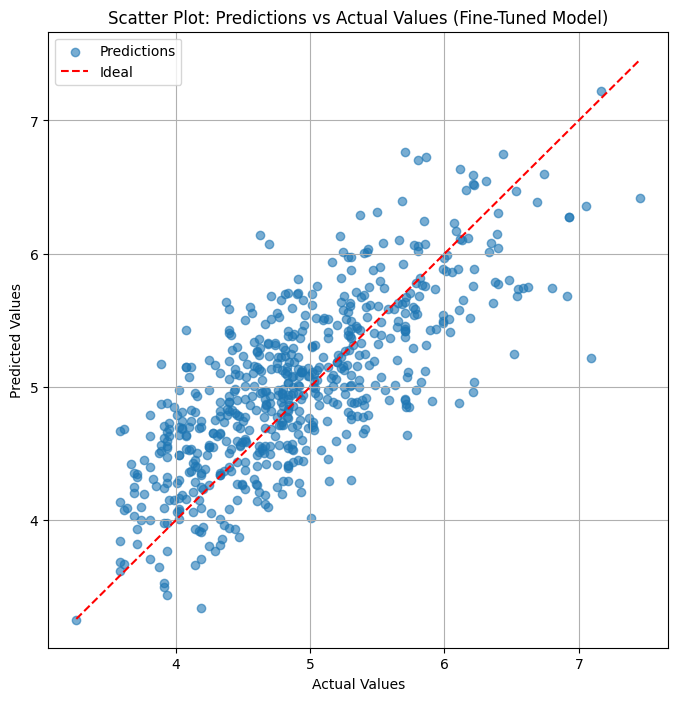

In [ ]:
# Evaularmodelo fine-tune en el conjunto de prueba
results_test = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {results_test[0]}, Test MAE: {results_test[1]}")

# Generar predicciones
y_pred_test = model.predict(test_dataset)

# Scatter plot para predicciones vs valores reales
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.6, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Ideal")
plt.title("Scatter Plot: Predictions vs Actual Values (Fine-Tuned Model)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()


## **Dsitribución fine-tune MobileNetV2**

Las predicciones muestran una buena alineación con los valores reales, con una clara tendencia a lo largo de la línea ideal pero hay cierta dispersión en los extremos, no hay patrones de sesgo evidentes.

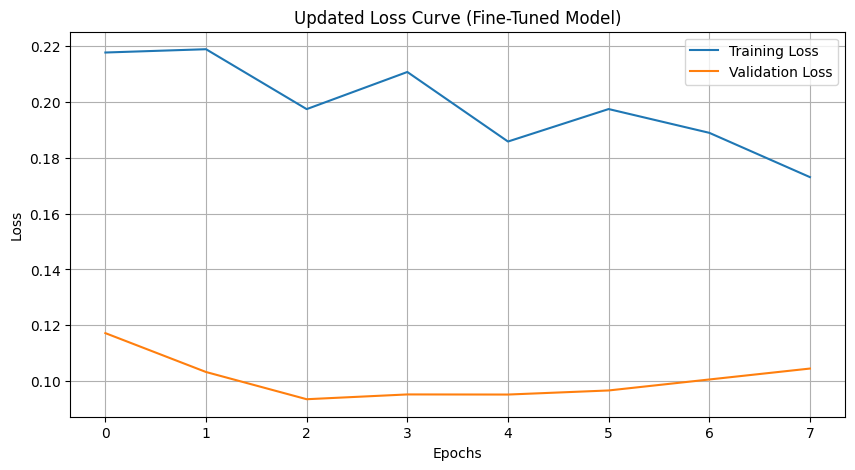

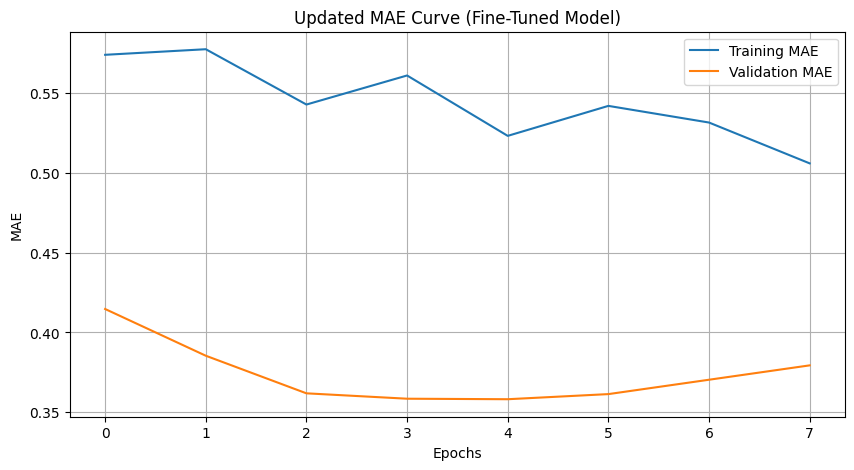

In [ ]:
# Plot curva loss
plt.figure(figsize=(10, 5))
plt.plot(history_finetuned.history["loss"], label="Training Loss")
plt.plot(history_finetuned.history["val_loss"], label="Validation Loss")
plt.title("Updated Loss Curve (Fine-Tuned Model)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot curva MAE
plt.figure(figsize=(10, 5))
plt.plot(history_finetuned.history["mae"], label="Training MAE")
plt.plot(history_finetuned.history["val_mae"], label="Validation MAE")
plt.title("Updated MAE Curve (Fine-Tuned Model)")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()



El modelo está bien entrenado inicialmente, pero a medida que avanza el entrenamiento, comienza a sobreajustarse.
Las líneas separadas muestran que el modelo no está generalizando de manera óptima en el conjunto de validación.



## **Plan:**
Ajustaré el lr con el schedule para disminuir el lr dinamicamente en entrenamiento. Asi podria alcanzar a que converga mejor sin sobrepasarse.


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define el lr scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.5  # Reduce lr a mitad depués de época 5

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Re-entrenar fine-tuned model con lr scheduler
history_lr_adjusted = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[lr_scheduler, early_stopping],
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

# Guardar modelo re-entrenado LR_Tuned
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_MobileNetV2_LR_Tuned.keras")

print("Model with adjusted learning rate has been saved.")



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 123s 934ms/step - loss: 0.2016 - mae: 0.5480 - val_loss: 0.0935 - val_mae: 0.3569 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/10
  1/132 ━━━━━━━━━━━━━━━━━━━━ 1:09 529ms/step - loss: 0.2368 - mae: 0.6480

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - loss: 0.2368 - mae: 0.6480 - val_loss: 0.0935 - val_mae: 0.3566 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - loss: 0.2020 - mae: 0.5515 - val_loss: 0.0940 - val_mae: 0.3577 - learning_rate: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - loss: 0.0633 - mae: 0.2685 - val_loss: 0.0941 - val_mae: 0.3577 - learning_rate: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 163s 885ms/step - loss: 0.2030 - mae: 0.5551 - val_loss: 0.0950 - val_mae: 0.3588 - learning_rate: 1.0000e-05

Epoch 6: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - loss: 0.2295 - mae: 0.6068 - val_loss: 

## **Análisis de Resultados modelo re entrenado fine-tune-lr**

La pérdida de validación (0.0935) y el MAE (0.3569) muestran una estabilización, pero no se observa una mejora significativa después de las primeras épocas. Reducir aún más lr no tuvo un impacto notable en el rendimiento del modelo.

El modelo alcanzó un punto de estancamiento, lo que indica que ajustar solo la tasa de aprendizaje puede no mejorar el rendimiento adicionalmente.

Ajustaré el batck size a uno mas grande para equilibrar la estabilidad y la velocidad de convergencia.

Ajustaré las capas de dropout en la parte densa del modelo para reducir aún más el sobreajuste.

Desbloquearé más capas de la red backbone MobileNetV2 para entrenamiento.

In [ ]:
# Aumentar batch size
batch_size = 64
steps_per_epoch = len(X_train_imgs) // batch_size

# Re-entrenar con nuevo batch size
history_batch_adjusted = model.fit(
    train_dataset.repeat(),
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Guardar modelo actualizado fine-tune-batch
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_MobileNetV2_Batch_Tuned.keras")

print("Model with adjusted batch size has been saved.")



Epoch 1: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.2315 - mae: 0.5944 - val_loss: 0.0926 - val_mae: 0.3547 - learning_rate: 2.5000e-06

Epoch 2: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.2178 - mae: 0.5777 - val_loss: 0.0924 - val_mae: 0.3539 - learning_rate: 2.5000e-06

Epoch 3: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.1850 - mae: 0.5249 - val_loss: 0.0926 - val_mae: 0.3545 - learning_rate: 2.5000e-06

Epoch 4: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.2157 - mae: 0.5660 - val_loss: 0.0945 - val_mae: 0.3571 - learning_rate: 2.5000e-06

Epoch 5: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 5/10
33/33 ━━━━━━━

## **Análisis de resultados modelo re entrenado fine-tune-batch**

La pérdida de validación (0.0924) y el MAE (0.3539) han mejorado ligeramente en las épocas iniciales, pero se han estabilizado posteriormente. Las tendencias de la pérdida y el MAE sugieren retornos decrecientes al ajustar únicamente la disminución de la tasa de aprendizaje y el tamaño del lote.

La tasa de aprendizaje es muy baja y una reducción adicional no está generando mejoras significativas. El modelo ha alcanzado los límites de lo que puede aprender con la arquitectura y las características actuales.

# **Plan:**

Actualmente, solo se están utilizando las últimas 20 capas de MobileNetV2 para el entrenamiento. Mmás capas podría ayudar a mejorar el rendimiento.

Introduciré capas de dropout o regularización L2 para mejorar la capacidad de generalización.

In [ ]:
# Desbloquear mas capas MobileNetV2
for layer in mobilenet.layers[-50:]:
    layer.trainable = True

# Recomilar con lr mas bajo
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=LogCosh(),
    metrics=["mae"]
)

print("Model has been updated to fine-tune additional layers.")


Model has been updated to fine-tune additional layers.


In [ ]:
# Re-entrenar con mas capas
history_further_finetuned = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

print("Model retrained with additional fine-tuned layers.")


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 165s 962ms/step - loss: 0.1937 - mae: 0.5395 - val_loss: 0.0957 - val_mae: 0.3632
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 134s 900ms/step - loss: 0.1987 - mae: 0.5418 - val_loss: 0.1053 - val_mae: 0.3834
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 149s 956ms/step - loss: 0.1736 - mae: 0.5089 - val_loss: 0.0961 - val_mae: 0.3647
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 121s 911ms/step - loss: 0.1812 - mae: 0.5202 - val_loss: 0.0974 - val_mae: 0.3678
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 138s 877ms/step - loss: 0.1854 - mae: 0.5271 - val_loss: 0.0999 - val_mae: 0.3729
Model retrained with additional fine-tuned layers.


## **Análisis de resultados modelo re entrenado + capas**

Hay sobreajuste, ya que la pérdida de validación y el MAE no están mejorando mientras que las métricas de entrenamiento sí lo hacen.

**Plan:**

Agregar regularización y ajustar lr para combatir el sobreajuste y estabilizar el proceso de entrenamiento.


In [ ]:
from tensorflow.keras.regularizers import l2

# Añadir L2 a todas las capas descongeladas
for layer in model.layers:
    if layer.trainable:
        layer.kernel_regularizer = l2(0.01)

# Recompilar después de añadir L2
model.compile(
    optimizer=optimizer,
    loss=LogCosh(),
    metrics=['mae']
)

print("Regularization added to the model and recompiled.")


Regularization added to the model and recompiled.


In [ ]:
# Ajustar lr
optimizer.learning_rate = 1e-6  # Reducir lr

# Recompilar
model.compile(
    optimizer=optimizer,
    loss=LogCosh(),
    metrics=['mae']
)

print("Learning rate reduced for fine-tuning.")


Learning rate reduced for fine-tuning.


In [ ]:
history_regularized = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

print("Model retrained with regularization and adjusted learning rate.")


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 128s 882ms/step - loss: 0.1850 - mae: 0.5257 - val_loss: 0.1009 - val_mae: 0.3767
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 143s 891ms/step - loss: 0.1959 - mae: 0.5416 - val_loss: 0.1076 - val_mae: 0.3924
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 138s 863ms/step - loss: 0.1918 - mae: 0.5355 - val_loss: 0.1105 - val_mae: 0.3985
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 145s 884ms/step - loss: 0.1800 - mae: 0.5117 - val_loss: 0.1206 - val_mae: 0.4174
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 122s 921ms/step - loss: 0.1965 - mae: 0.5402 - val_loss: 0.1202 - val_mae: 0.4167
Model retrained with regularization and adjusted learning rate.


## **Análisis problema modelo MobileNetV2 fine-tune**

Los resultados indican que agregar regularización L2 y reducir lr no resultaron en una mejora significativa. La pérdida de validación y el MAE han aumentado, lo que sugiere que el modelo aún podría estar sobreajustándose o teniendo dificultades para generalizar.


**MobileNetV2 podría no ser lo suficientemente compleja** para el conjunto de datos.


El estancamiento del MAE alrededor de 0.5 podría indicar que el modelo esta atrapado en un infraajuste.


# **CAMBIO DE ARQUITECTURA NUEVAMENTE: EfficientNet**
La extracción de características desde MobileNetV2 puede ser insuficiente o subóptima.

Usaré ahora una red preentrenada más potente como ***EfficientNet.***


Añade capas densas y Dropout para aprendizaje complejo y prevenir sobreajuste.

EfficientNetB0 congelado actúa como extractor de características; las capas nuevas integran datos tabulares.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Utilización de EfficientNetB0 para extraccion de caracterísiticas
efficient_net = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"
)

# Congelar las capas del EfficientNet
efficient_net.trainable = False

print("EfficientNetB0 initialized and frozen for feature extraction.")


EfficientNetB0 initialized and frozen for feature extraction.


In [ ]:
from tensorflow.keras.layers import Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import LogCosh
from tensorflow.keras.models import Model

# Input data tabular
input_tabular = Input(shape=(X_train_tab.shape[1],), name="tabular_input")

# EfficientNetB0 outputs
image_features = efficient_net.output

# Combinar características de imágenes y tabulares
combined = Concatenate()([image_features, input_tabular])

# Añadir capas densas despues de concatenación
x = Dense(256, activation="relu")(combined)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="linear")(x)

# Crear modelo full
full_model = Model(inputs=[efficient_net.input, input_tabular], outputs=output)

# Compilar modelo
full_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for stability
    loss=LogCosh(),  # Log-Cosh for robust regression
    metrics=["mae"]
)

# Summary del modelo
full_model.summary()

print("Full model with EfficientNet and tabular integration is ready.")


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,419,748 (16.86 MB)

 Trainable params: 370,177 (1.41 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Full model with EfficientNet and tabular integration is ready.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Configure Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train the model
history = full_model.fit(
    [X_train_imgs, X_train_tab], y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

print("Training completed. Model has been trained and validated.")


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - loss: 2.4160 - mae: 3.0638 - val_loss: 0.2756 - val_mae: 0.6561
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - loss: 0.4112 - mae: 0.8389 - val_loss: 0.1280 - val_mae: 0.4274
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - loss: 0.3471 - mae: 0.7555 - val_loss: 0.1168 - val_mae: 0.3990
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - loss: 0.2997 - mae: 0.6927 - val_loss: 0.0829 - val_mae: 0.3380
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - loss: 0.2845 - mae: 0.6725 - val_loss: 0.1002 - val_mae: 0.3615
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - loss: 0.2232 - mae: 0.5823 - val_loss: 0.0758 - val_mae: 0.3068
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - loss: 0.2297 - mae: 0.5921 - val_loss: 0.0591 - val_mae: 0.2673
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - loss: 0.2104 - mae: 0.5643 - val_loss: 0.0527 - val_mae: 0.2509
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - loss: 0.207

## **Evaluación en Test Modelo EfficientNet:**

20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.1068 - mae: 0.3885
Test Loss: 0.11012100428342819, Test MAE: 0.39579126238822937
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step


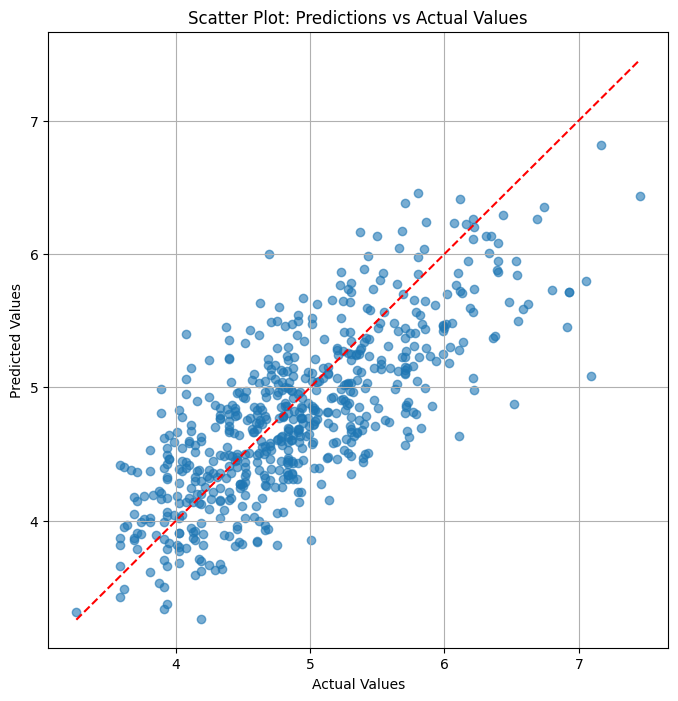

In [ ]:
# Evalaución de test
results_test = model.evaluate([X_test_imgs, X_test_tab], y_test, verbose=1)
print(f"Test Loss: {results_test[0]}, Test MAE: {results_test[1]}")

# Predicciones en test
y_pred = model.predict([X_test_imgs, X_test_tab])

# Scatter Plot Predictions vs Actual Values
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Scatter Plot: Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.grid()
plt.show()


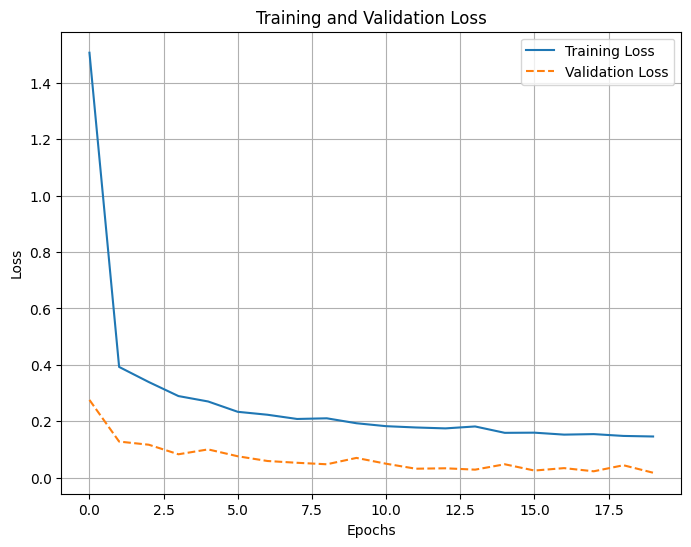

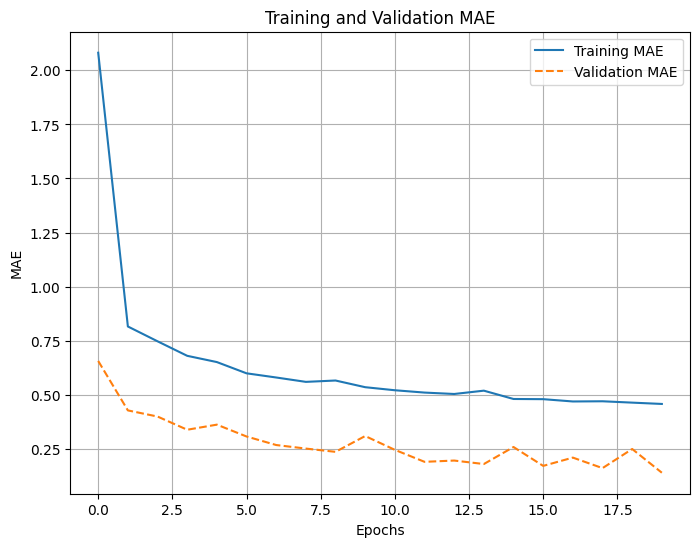

In [ ]:
# Plot val- loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot val - MAE
plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Save the trained EfficientNet model
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_EfficientNetB0_trained.keras")
print("Model saved successfully!")


Model saved successfully!


## **Análisis métricas Modelo EfficientNet:**

Pérdida y MAE de Prueba:

Pérdida: 0.1101
MAE: 0.3958 (error promedio ~48.5% en precios reales). Mejor que modelos anteriores, pero no suficiente para aplicaciones confiables.

Mejora en la alineación con la línea ideal.
Menos valores atípicos, mejor generalización, pero aún problemas con propiedades extremas (lujo o bajo valor).

Pérdida de entrenamiento y validación disminuyen consistentemente.
Sin sobreajuste; el modelo generaliza bien a datos no vistos.

MAE de entrenamiento y validación descienden, confirmando aprendizaje efectivo.

***Fortalezas modelo:***

Generaliza sin sobreajustar.
MAE mejor que iteraciones previas.
Arquitectura compacta (EfficientNetB0) con buen desempeño.

***Debilidades:***

Predicciones pobres para propiedades de lujo o bajo costo.
Un 48.5% es inaceptable para sistemas de producción.
Datos tabulares podrían mejorar el rendimiento.

# **Fusion EfficientNet + ResNet:**

Craré un modelo híbrido, combinando las salidas de ambos para capturar mejor las características por medio de fine-tuning.

La fusion la hare con los que dieron un "mejor" resultado de todas las pruebas que se han ehcho entre ResNet y EfficientNet.


Implementaré DropBlock, mas avanzado que le dropout que apaga bloques enteros de características y MixUp que combina imágenes para crear otras nuevas intermedias y ayudará al modelo a ser mas robusto.

Aumentaré los datos de manera más agresiva.

Ajustaré la tasa de aprendizaje ciclica para encontrar un lr optimo.

Después de entrenar estos modelos, aplicaré un ensemble.

In [ ]:
import numpy as np

# Rutas de los archivos .npy con las imágenes
train_imgs_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_224.npy"
val_imgs_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_224.npy"
test_imgs_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_224.npy"

# Cargar las imágenes desde los archivos .npy
X_train_imgs = np.load(train_imgs_path)
X_val_imgs = np.load(val_imgs_path)
X_test_imgs = np.load(test_imgs_path)

# Verificar las formas de las imágenes cargadas
print(f"Forma de las imágenes de entrenamiento: {X_train_imgs.shape}")
print(f"Forma de las imágenes de validación: {X_val_imgs.shape}")
print(f"Forma de las imágenes de prueba: {X_test_imgs.shape}")


Forma de las imágenes de entrenamiento: (2125, 224, 224, 3)
Forma de las imágenes de validación: (376, 224, 224, 3)
Forma de las imágenes de prueba: (627, 224, 224, 3)


In [ ]:
import pandas as pd
# Cargar datos tabulares escalados
X_train_tab = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_train_finpreprocesado.csv", sep=';').values
X_val_tab = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_val_finpreprocesado.csv", sep=';').values
X_test_tab = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_test_finpreprocesado.csv", sep=';').values

# Cargar etiquetas
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")


In [ ]:
import numpy as np

# Cargar las imágenes de entrenamiento, validación y prueba
X_train_resnet = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_224.npy")
X_val_resnet = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_224.npy")
X_test_resnet = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_224.npy")

# Si las etiquetas no se han cargado aún, carga las etiquetas correspondientes (y_train, y_val, y_test)
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")


## **Análisis de Importancia de Características Tabulares**
Análisis de importancia de características tabulares usando Permutation Importance. Este método evalúa el impacto de cada característica en las métricas del modelo al alterar sus valores

In [3]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Cargar imágenes normalizadas y redimensionadas
X_train_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_224.npy")
X_val_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_224.npy")
X_test_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_224.npy")

# Cargar datos tabulares escalados
X_train_tab = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_train_finpreprocesado.csv", sep=';').values
X_val_tab = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_val_finpreprocesado.csv", sep=';').values
X_test_tab = pd.read_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/fd_test_finpreprocesado.csv", sep=';').values

# Cargar etiquetas
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")

# Verificar dimensiones
print("Dimensiones de los datos:")
print(f"Imágenes (train): {X_train_imgs.shape}, Tabular (train): {X_train_tab.shape}, Etiquetas (train): {y_train.shape}")
print(f"Imágenes (val): {X_val_imgs.shape}, Tabular (val): {X_val_tab.shape}, Etiquetas (val): {y_val.shape}")
print(f"Imágenes (test): {X_test_imgs.shape}, Tabular (test): {X_test_tab.shape}, Etiquetas (test): {y_test.shape}")

# Verificar sincronización entre imágenes y datos tabulares
assert len(X_train_imgs) == len(X_train_tab) == len(y_train), "Dimensiones no coinciden en conjunto de entrenamiento"
assert len(X_val_imgs) == len(X_val_tab) == len(y_val), "Dimensiones no coinciden en conjunto de validación"
assert len(X_test_imgs) == len(X_test_tab) == len(y_test), "Dimensiones no coinciden en conjunto de prueba"

print("Verificación completada: los conjuntos están correctamente sincronizados y preparados.")


Dimensiones de los datos:
Imágenes (train): (2125, 224, 224, 3), Tabular (train): (2125, 36), Etiquetas (train): (2125,)
Imágenes (val): (376, 224, 224, 3), Tabular (val): (376, 36), Etiquetas (val): (376,)
Imágenes (test): (627, 224, 224, 3), Tabular (test): (627, 36), Etiquetas (test): (627,)
Verificación completada: los conjuntos están correctamente sincronizados y preparados.


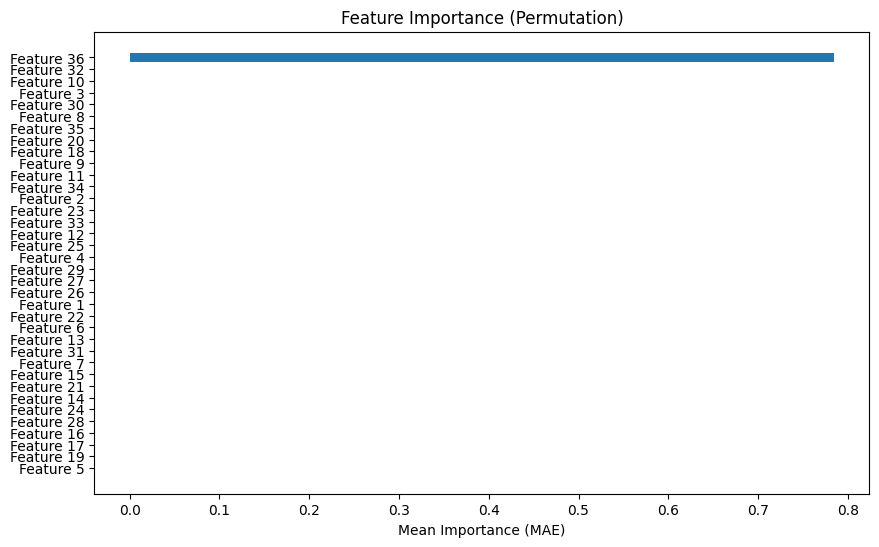

Top 10 características más importantes:
Feature 36 - Importancia: 0.7849
Feature 32 - Importancia: 0.0001
Feature 10 - Importancia: 0.0001
Feature 3 - Importancia: 0.0000
Feature 30 - Importancia: 0.0000
Feature 8 - Importancia: 0.0000
Feature 35 - Importancia: 0.0000
Feature 20 - Importancia: 0.0000
Feature 18 - Importancia: 0.0000
Feature 9 - Importancia: 0.0000


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Entrenar un modelo base para evaluar importancia
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_tab, y_train)

# Calcular importancia por permutación
result = permutation_importance(rf_model, X_val_tab, y_val, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')

# Extraer importancias
importances = result.importances_mean
feature_indices = np.argsort(importances)[::-1]  # Ordenar de mayor a menor
feature_names = [f"Feature {i+1}" for i in range(X_train_tab.shape[1])]

# Gráfico de importancias
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[feature_indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in feature_indices])
plt.xlabel("Mean Importance (MAE)")
plt.title("Feature Importance (Permutation)")
plt.gca().invert_yaxis()  # Para mostrar el más importante arriba
plt.show()

# Imprimir las 10 características más importantes
print("Top 10 características más importantes:")
for i in feature_indices[:10]:
    print(f"{feature_names[i]} - Importancia: {importances[i]:.4f}")


 El resultado indica que una sola característica (Feature 36 - price_log) está dominando completamente el modelo en términos de importancia, mientras que las demás tienen valores insignificantes o cercanos a cero.


**Análisis las 3 características fuera de rango:**

**Feature 1 (Host Response):**
Representa una categorización de 1 a 4 según la rapidez de respuesta del anfitrión.
Opinión: Su rango limitado (1-4) no es un problema grave, ya que es una codificación categórica discreta con valores claros de significancia.

**Feature 8 (Neighbourhood):**
Codificación numérica de barrios con label encoder.Se podria aplicar un enfoque más adecuado como clusters para garantizar que no domine el modelo debido a su rango amplio.

**Feature 36 (Price, log-transformada):**
LLeva una transformación logarítmica, lo cual es válido porque comprime los valores extremos. Sin embargo, su rango sigue siendo mayor que el de otras características.


In [5]:
# Verificar estadísticas básicas de las características tabulares
import numpy as np
import pandas as pd

# Convertir datos a DataFrame para análisis
df_train_tab = pd.DataFrame(X_train_tab, columns=[f"Feature {i+1}" for i in range(X_train_tab.shape[1])])

# Calcular estadísticas básicas
feature_stats = df_train_tab.describe().T  # Transponer para mejor visualización
feature_stats["range"] = feature_stats["max"] - feature_stats["min"]

# Mostrar las estadísticas principales
print("Estadísticas principales de las características tabulares:")
print(feature_stats[["mean", "std", "min", "max", "range"]])

# Verificar si hay características con rangos muy diferentes
large_range_features = feature_stats[feature_stats["range"] > 1]
if not large_range_features.empty:
    print("\n⚠️ Características con rangos altos (no están correctamente escaladas):")
    print(large_range_features)
else:
    print("\n✅ Todas las características parecen estar correctamente escaladas.")


Estadísticas principales de las características tabulares:
                 mean       std       min       max      range
Feature 1    3.751059  0.588380  1.000000   4.00000   3.000000
Feature 2    0.950816  0.121952  0.010000   0.99000   0.980000
Feature 3    0.886985  0.186529  0.010000   0.99000   0.980000
Feature 4    0.328941  0.469939  0.000000   1.00000   1.000000
Feature 5    0.364451  0.273982  0.010000   0.99000   0.980000
Feature 6    0.988706  0.105697  0.000000   1.00000   1.000000
Feature 7    0.902118  0.297225  0.000000   1.00000   1.000000
Feature 8   13.165176  7.583838  1.000000  27.00000  26.000000
Feature 9    0.636092  0.175739  0.010000   0.99000   0.980000
Feature 10   0.511750  0.178363  0.010000   0.99000   0.980000
Feature 11   0.204952  0.197600  0.010000   0.99000   0.980000
Feature 12   0.395082  0.177916  0.010000   0.99000   0.980000
Feature 13   0.149368  0.213007  0.010000   0.99000   0.980000
Feature 14   0.127534  0.190248  0.010000   0.99000   0.980

## **Grafica de correlaciones entre estas características y el precio**

Correlaciones entre características seleccionadas y precio (Feature 36):
Feature 1 (Host Response)    0.053410
Feature 8 (Neighborhoods)    0.027791
Feature 36 (Price - log)     1.000000
Name: Feature 36 (Price - log), dtype: float64


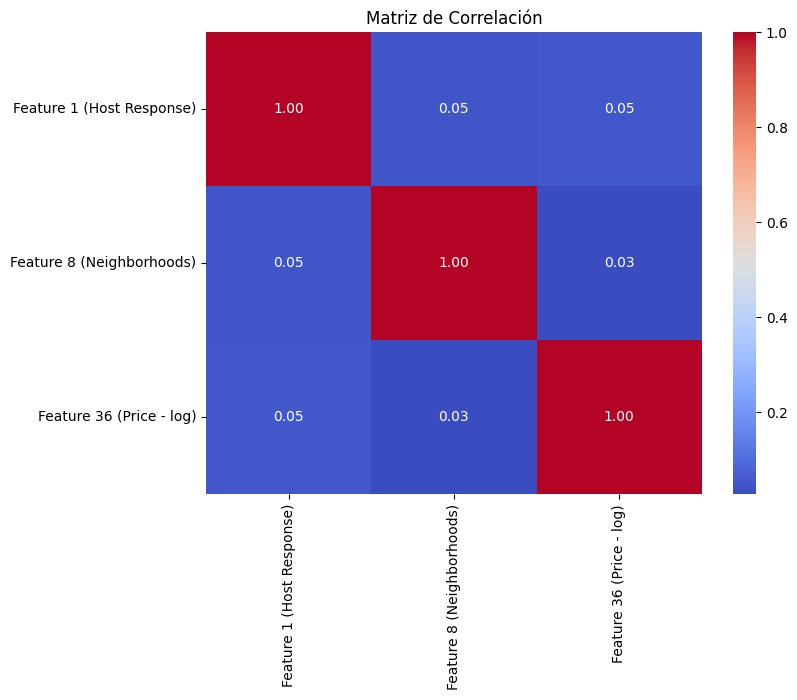

In [6]:
import pandas as pd
import numpy as np

# Crear DataFrame con las tres características clave y el precio
df_selected = pd.DataFrame({
    "Feature 1 (Host Response)": X_train_tab[:, 0],  # Primera columna: Feature 1
    "Feature 8 (Neighborhoods)": X_train_tab[:, 7],  # Octava columna: Feature 8
    "Feature 36 (Price - log)": X_train_tab[:, 35],  # Última columna: Feature 36 (precio log)
})

# Calcular correlación entre las características seleccionadas
correlations = df_selected.corr()

# Mostrar las correlaciones
print("Correlaciones entre características seleccionadas y precio (Feature 36):")
print(correlations["Feature 36 (Price - log)"])

# Visualizar matriz de correlación completa con heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matriz de Correlación")
plt.show()


## **Alternativa de agrupación por clusters:**

Puedo realizar una agrupación de vecindarios basada en precios promedio por barrio utilizando clustering.

Reduciria el rango actual de la característica (1 a 27) a un número más manejable de grupos (clusters).

Mantener la representación semántica del vecindario como una única columna numérica sin afectar la estructura actual de los datos.

**Plan:**

Cálcularé precios promedio por vecindario usando el conjunto de entrenamiento.

Usaré K-Means para agrupar los vecindario en categorías similares (por ejemplo, barrios "económicos", "moderados", "caros").

Reemplazaré la columna de vecindario por el cluster correspondiente en todos los conjuntos (entrenamiento, validación y prueba).

Haré una transformación directa sobre los conjuntos ya divididos (train, val, test)

# **Calcular precios promedio por vecindario usando Feature 8 - Neighbourhood en el conjunto de entrenamiento**

In [7]:
import pandas as pd
import numpy as np

# Crear DataFrame con el vecindario (Feature 8) y el precio (Feature 36)
df_train_neighborhood = pd.DataFrame({
    "Neighborhood": X_train_tab[:, 7],  # Feature 8: Vecindario
    "Price (log)": y_train              # Precio (log transformado)
})

# Calcular el precio promedio por vecindario
neighborhood_avg_price = df_train_neighborhood.groupby("Neighborhood")["Price (log)"].mean()

# Mostrar los precios promedio por vecindario
print("Precios promedio por vecindario (log transformados):")
print(neighborhood_avg_price)

# Guardar esta información para referencia
neighborhood_avg_price.to_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/neighborhood_avg_price.csv")

print("\nArchivo 'neighborhood_avg_price.csv' guardado con éxito.")


Precios promedio por vecindario (log transformados):
Neighborhood
1.0     4.595639
2.0     5.081873
3.0     4.991180
4.0     4.909358
6.0     4.658092
7.0     5.347458
8.0     5.265231
10.0    4.566155
11.0    5.246210
12.0    4.820618
13.0    4.910796
14.0    4.590178
15.0    5.033946
16.0    5.401824
17.0    5.336116
18.0    4.589452
19.0    4.621353
20.0    5.162530
21.0    4.855210
22.0    4.573637
23.0    4.950082
24.0    5.594957
25.0    5.053788
26.0    5.230672
27.0    4.878464
Name: Price (log), dtype: float64

Archivo 'neighborhood_avg_price.csv' guardado con éxito.


# **Agrupar Neighbourhood - Feature 8 en clusters:**

3 clusters: económico, moderado, caro.

In [8]:
from sklearn.cluster import KMeans
import pandas as pd

# Convertir los precios promedio a un formato adecuado para clustering
avg_price_values = neighborhood_avg_price.values.reshape(-1, 1)

# Definir el número de clusters
num_clusters = 3

# Aplicar K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
neighborhood_clusters = kmeans.fit_predict(avg_price_values)

# Crear un mapa de vecindarios a clusters
neighborhood_to_cluster = {
    neighborhood: cluster for neighborhood, cluster in zip(neighborhood_avg_price.index, neighborhood_clusters)
}

# Mostrar el mapa de vecindarios a clusters
print("Asignación de vecindarios a clusters:")
print(neighborhood_to_cluster)

# Guardar el mapa en un archivo CSV para referencia futura
pd.DataFrame(list(neighborhood_to_cluster.items()), columns=["Neighborhood", "Cluster"]).to_csv(
    "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/neighborhood_clusters.csv", index=False
)

print("\nArchivo 'neighborhood_clusters.csv' guardado con éxito.")


Asignación de vecindarios a clusters:
{1.0: 2, 2.0: 0, 3.0: 0, 4.0: 0, 6.0: 2, 7.0: 1, 8.0: 1, 10.0: 2, 11.0: 1, 12.0: 0, 13.0: 0, 14.0: 2, 15.0: 0, 16.0: 1, 17.0: 1, 18.0: 2, 19.0: 2, 20.0: 1, 21.0: 0, 22.0: 2, 23.0: 0, 24.0: 1, 25.0: 0, 26.0: 1, 27.0: 0}

Archivo 'neighborhood_clusters.csv' guardado con éxito.


# **Reemplazar Feature 8 por clusters:**

In [9]:
# Crear una función para asignar clusters a los conjuntos de datos
def assign_clusters(tab_data, cluster_map, feature_index=7):
    # Reemplazar vecindarios con sus clusters
    updated_tab_data = tab_data.copy()
    updated_tab_data[:, feature_index] = np.array([cluster_map[neighborhood] for neighborhood in tab_data[:, feature_index]])
    return updated_tab_data

# Asignar clusters a los conjuntos
X_train_tab_updated = assign_clusters(X_train_tab, neighborhood_to_cluster)
X_val_tab_updated = assign_clusters(X_val_tab, neighborhood_to_cluster)
X_test_tab_updated = assign_clusters(X_test_tab, neighborhood_to_cluster)

# Guardar los nuevos conjuntos de datos con clusters
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_train_tab_with_clusters.npy", X_train_tab_updated)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_val_tab_with_clusters.npy", X_val_tab_updated)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_test_tab_with_clusters.npy", X_test_tab_updated)

print("Los conjuntos de datos actualizados con clusters han sido guardados:")
print("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_train_tab_with_clusters.npy")
print("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_val_tab_with_clusters.npy")
print("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_test_tab_with_clusters.npy")


Los conjuntos de datos actualizados con clusters han sido guardados:
/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_train_tab_with_clusters.npy
/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_val_tab_with_clusters.npy
/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_test_tab_with_clusters.npy


## **Guardar los nuevos conjuntos actualizados con la transformación:**


In [10]:
# Cargar los nuevos conjuntos de datos tabulares con clusters
X_train_tab = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_train_tab_with_clusters.npy")
X_val_tab = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_val_tab_with_clusters.npy")
X_test_tab = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_test_tab_with_clusters.npy")

# Verificar dimensiones
print("Dimensiones de los conjuntos actualizados:")
print(f"X_train_tab: {X_train_tab.shape}")
print(f"X_val_tab: {X_val_tab.shape}")
print(f"X_test_tab: {X_test_tab.shape}")

# Confirmar sincronización con imágenes y etiquetas
assert X_train_tab.shape[0] == y_train.shape[0] == X_train_imgs.shape[0], "Desincronización en conjunto de entrenamiento"
assert X_val_tab.shape[0] == y_val.shape[0] == X_val_imgs.shape[0], "Desincronización en conjunto de validación"
assert X_test_tab.shape[0] == y_test.shape[0] == X_test_imgs.shape[0], "Desincronización en conjunto de prueba"

print("✔️ Conjuntos actualizados correctamente sincronizados con imágenes y etiquetas.")


Dimensiones de los conjuntos actualizados:
X_train_tab: (2125, 36)
X_val_tab: (376, 36)
X_test_tab: (627, 36)
✔️ Conjuntos actualizados correctamente sincronizados con imágenes y etiquetas.


## **En caso de inicialización de notebook, ahora debo cargar estos conjuntos:**

In [ ]:
# Importar librerías necesarias
import numpy as np
import pandas as pd

# Cargar imágenes normalizadas y redimensionadas
X_train_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_224.npy")
X_val_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_224.npy")
X_test_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_224.npy")

# Cargar conjuntos tabulares actualizados con clusters
X_train_tab = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_train_tab_with_clusters.npy")
X_val_tab = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_val_tab_with_clusters.npy")
X_test_tab = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_test_tab_with_clusters.npy")

# Cargar etiquetas
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")

# Verificar dimensiones y sincronización
print("Dimensiones de los datos:")
print(f"Imágenes (train): {X_train_imgs.shape}, Tabular (train): {X_train_tab.shape}, Etiquetas (train): {y_train.shape}")
print(f"Imágenes (val): {X_val_imgs.shape}, Tabular (val): {X_val_tab.shape}, Etiquetas (val): {y_val.shape}")
print(f"Imágenes (test): {X_test_imgs.shape}, Tabular (test): {X_test_tab.shape}, Etiquetas (test): {y_test.shape}")

assert X_train_tab.shape[0] == y_train.shape[0] == X_train_imgs.shape


# **Entrenaré el mi último modelo EfficientNetB0 para actualizarlo con los conjuntos ajustados:**

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

# Cargar el modelo existente si está guardado o definirlo de nuevo
model_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_EfficientNetB0_trained.keras"

try:
    # Intentar cargar el modelo previamente guardado
    full_model = load_model(model_path)
    print("Modelo EfficientNetB0 cargado exitosamente.")
except:
    print("No se pudo cargar el modelo existente. Asegúrate de tenerlo disponible o de definirlo nuevamente.")

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Entrenar el modelo con los conjuntos actualizados
history = full_model.fit(
    [X_train_imgs, X_train_tab], y_train,
    validation_data=([X_val_imgs, X_val_tab], y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Guardar el modelo entrenado nuevamente
full_model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/modelo_EfficientNetB0_trained_with_clusters.keras")
print("Modelo actualizado y guardado como 'modelo_EfficientNetB0_trained_with_clusters.keras'.")


Modelo EfficientNetB0 cargado exitosamente.
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - loss: 4.0189 - mae: 0.5563 - val_loss: 3.8852 - val_mae: 0.3327
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - loss: 3.9956 - mae: 0.5373 - val_loss: 3.8723 - val_mae: 0.3217
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 3.9814 - mae: 0.5264 - val_loss: 3.8637 - val_mae: 0.3189
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - loss: 3.9747 - mae: 0.5249 - val_loss: 3.8569 - val_mae: 0.3196
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - loss: 3.9552 - mae: 0.5084 - val_loss: 3.8509 - val_mae: 0.3208
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - loss: 3.9559 - mae: 0.5228 - val_loss: 3.8451 - val_mae: 0.3221
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - loss: 3.9614 - mae: 0.5377 - val_loss: 3.8395 - val_mae: 0.3235
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - loss: 3.9507 - mae: 0.5284 - val_loss: 3.8339 - val_mae: 0.3240
Epoch 9/20
67/67 ━━━

# **Métricas EfficientNetB0 con clusters:**

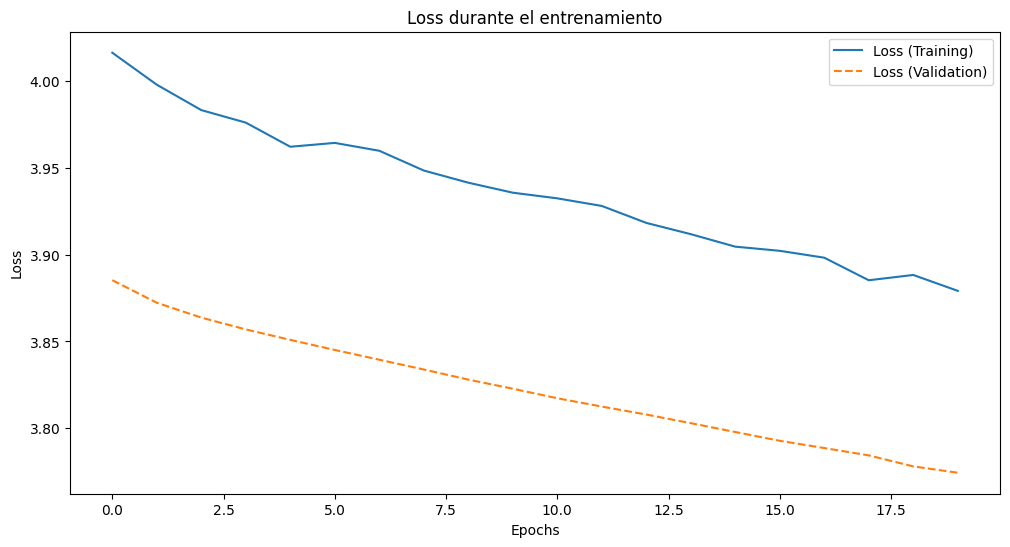

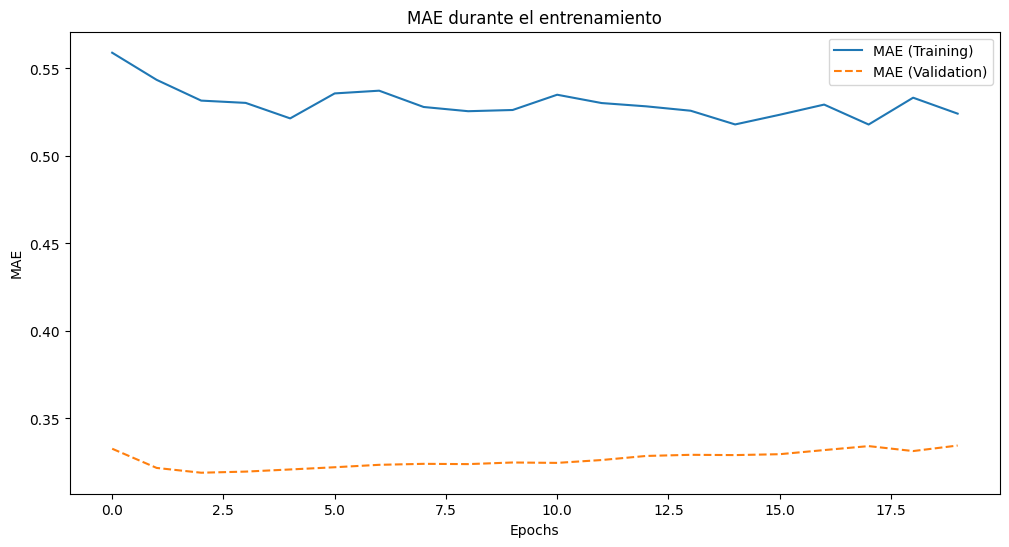

Últimas métricas obtenidas:
Loss en Validación: 3.774473190307617
MAE en Validación: 0.33448526263237


In [12]:
import matplotlib.pyplot as plt

# Obtener las métricas de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Graficar la pérdida (Loss)
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Loss (Training)')
plt.plot(val_loss, label='Loss (Validation)', linestyle='--')
plt.title('Loss durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar el MAE
plt.figure(figsize=(12, 6))
plt.plot(mae, label='MAE (Training)')
plt.plot(val_mae, label='MAE (Validation)', linestyle='--')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Mostrar las métricas finales
print("Últimas métricas obtenidas:")
print(f"Loss en Validación: {val_loss[-1]}")
print(f"MAE en Validación: {val_mae[-1]}")


In [13]:
# Generar predicciones en el conjunto de prueba
y_pred = full_model.predict([X_test_imgs, X_test_tab])

# Scatter plot de predicciones vs valores reales
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Línea ideal
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Scatter Plot: Predicciones vs Valores Reales")
plt.grid()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


# **Métricas EfficientNetB0 con clusters:**

Loss (Validación: 3.7744):

Se observa una disminución constante en ambas curvas (entrenamiento y validación).
Esto indica que el modelo está aprendiendo y no hay señales de sobreajuste.
MAE (Validación: 0.3345):

La métrica es bastante competitiva y sugiere una mejora en comparación con tus resultados previos.
El MAE en validación es razonablemente bajo, pero parece haberse estabilizado.

Scatter plot:
Alineación con la línea ideal (roja):

La mayoría de los puntos están cercanos a la línea roja (predicción ideal), lo que indica que el modelo realiza predicciones razonables.
Sin embargo, hay dispersión en valores más altos, lo que sugiere que el modelo podría estar teniendo dificultades con precios extremos.
Distribución de puntos:

Hay un patrón consistente en valores moderados (5-6 en escala logarítmica), lo cual es positivo.
La dispersión en los extremos puede deberse a datos más difíciles de modelar o ruido en los datos.

In [14]:
# Calcular MAPE
mape = np.mean(np.abs((y_test - y_pred.squeeze()) / y_test)) * 100
print(f"MAPE (Porcentaje de Error Promedio Absoluto): {mape:.2f}%")


MAPE (Porcentaje de Error Promedio Absoluto): 7.31%


Un MAPE del 7.31% significa que, en promedio, las predicciones del modelo tienen un error absoluto del 7.31% respecto a los precios reales. Este es un porcentaje muy competitivo para un modelo de regresión, especialmente considerando la naturaleza compleja de los precios en Airbnb.

Alto rendimiento del modelo:

Un MAPE por debajo del 10% generalmente se considera excelente en problemas de predicción de precios, lo que indica que tu modelo es confiable.
Impacto de los clusters:

Incorporar los clusters para neighbourhood_cleansed parece haber beneficiado al modelo, mejorando su capacidad para capturar patrones importantes sin ruido adicional.
Gráficas de loss y MAE:

Las gráficas de loss y MAE son consistentes con el bajo MAPE. La diferencia pequeña entre las curvas de entrenamiento y validación refuerza que el modelo está generalizando bien.

In [15]:
import pandas as pd
import numpy as np

# Transformar valores de logaritmo a precios originales
y_test_original = np.exp(y_test)
y_pred_original = np.exp(y_pred.squeeze())

# Crear un DataFrame para visualizar la comparación
comparison_df = pd.DataFrame({
    "Precio Real": y_test_original,
    "Predicción": y_pred_original
})

# Mostrar las primeras filas de la comparación
print("Comparación de precios reales y predicciones (en precio original):")
print(comparison_df.head(10))

# Guardar la comparación en un archivo CSV para análisis adicional
comparison_df.to_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/comparison_real_vs_pred.csv", index=False)
print("\nArchivo 'comparison_real_vs_pred.csv' guardado con éxito.")


Comparación de precios reales y predicciones (en precio original):
   Precio Real  Predicción
0        150.0  166.241165
1        201.0  148.861740
2        153.0  109.722572
3        110.0  103.251221
4        154.0  202.878296
5        129.0  123.459740
6         50.0  132.464722
7         74.0   70.621437
8        136.0  101.608208
9        164.0  232.104202

Archivo 'comparison_real_vs_pred.csv' guardado con éxito.


Comparación de precios reales vs predicciones

valores cercanos:

En muchos casos, las predicciones están cerca de los precios reales, como en las filas 5 y 7 (123 vs 129 y 70 vs 74).
Esto refuerza que el modelo tiene un buen rendimiento en la mayoría de los casos.
Diferencias notables:

Hay algunos casos donde las predicciones se desvían más, como en la fila 4 (154 real vs 202 predicción) y la fila 9 (164 real vs 232 predicción).
Estas diferencias pueden deberse a vecindarios con poca representación en el conjunto de entrenamiento o valores extremos de precio.
Tendencia general:

A pesar de algunas discrepancias, el modelo parece captar bien los patrones generales de los precios.

**Examinar los casos donde las predicciones tienen mayor error absoluto (diferencia entre Precio Real y Predicción) para identificar patrones**

In [17]:
import pandas as pd
import numpy as np

# Calcular el error absoluto
comparison_df["Error Absoluto"] = np.abs(comparison_df["Precio Real"] - comparison_df["Predicción"])

# Ordenar por el mayor error absoluto
largest_errors = comparison_df.sort_values(by="Error Absoluto", ascending=False).head(10)

# Mostrar los 10 casos con mayor error absoluto
print("Casos con mayor error absoluto:")
print(largest_errors)

# Guardar estos casos en un archivo CSV para análisis adicional
largest_errors.to_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/largest_errors.csv", index=False)
print("\nArchivo 'largest_errors.csv' guardado con éxito.")


Casos con mayor error absoluto:
     Precio Real  Predicción  Error Absoluto
403       1730.0  718.190918     1011.809082
377       1160.0  349.525970      810.474030
128       1201.0  487.531281      713.468719
536       1018.0  320.026428      697.973572
574       1018.0  320.026428      697.973572
607       1001.0  406.346375      594.653625
59         109.0  579.069824      470.069824
88         675.0  207.644073      467.355927
300        244.0  659.574463      415.574463
203        433.0  829.954285      396.954285

Archivo 'largest_errors.csv' guardado con éxito.


Valores extremos (alta discrepancia):

Los casos más problemáticos son aquellos con precios reales muy altos (por ejemplo, 1730, 1160, 1201) donde el modelo subestima fuertemente.
Esto indica que el modelo puede estar teniendo dificultades para capturar valores altos, posiblemente por:
Un sesgo hacia valores más comunes en el entrenamiento.
Representación insuficiente de vecindarios o datos tabulares clave que diferencian estos valores extremos.
Sobreestimación en valores más bajos:

En casos como 109 (579 predicción) y 244 (659 predicción), el modelo sobreestima precios bajos, lo que también puede deberse a insuficientes datos o características que expliquen estos valores.
Duplicados en los errores:

Casos como 1018 (320 predicción) aparecen repetidos. Esto podría ser debido a datos tabulares o imágenes similares que conducen a predicciones repetidas.

Siguiente acción sugerida:
Análisis de datos tabulares e imágenes de estos casos:

Revisar si los vecindarios o características tabulares tienen patrones específicos en estos casos.
Analizar si las imágenes de estas propiedades (alta discrepancia) tienen características visuales claras que podrían ser más representativas.

**Análisis de datos tabulares e imágenes para los casos con mayor error absoluto**

Extrae los datos tabulares, imágenes y etiquetas asociadas a los casos con mayor error absoluto.
Genera un DataFrame con los datos tabulares de estos casos y sus predicciones para análisis detallado.
Guarda estos datos en un archivo CSV para un análisis más profundo.
Muestra las imágenes de estos casos junto con los precios reales y predicciones para detectar posibles patrones visuales.

In [19]:
# Obtener los índices de los casos con mayor error absoluto
indices_largest_errors = largest_errors.index

# Extraer las filas correspondientes de los datos tabulares y etiquetas
tabular_errors = X_test_tab[indices_largest_errors]
image_errors = X_test_imgs[indices_largest_errors]
labels_errors = y_test[indices_largest_errors]

# Mostrar los datos tabulares de estos casos
import pandas as pd

tabular_errors_df = pd.DataFrame(tabular_errors, columns=[f"Feature {i+1}" for i in range(X_test_tab.shape[1])])
tabular_errors_df["Precio Real"] = np.exp(labels_errors)  # Transformar precios reales al valor original
tabular_errors_df["Predicción"] = np.exp(largest_errors["Predicción"].values)
tabular_errors_df["Error Absoluto"] = largest_errors["Error Absoluto"].values

print("Datos tabulares de los casos con mayor error absoluto:")
print(tabular_errors_df)

# Guardar estos datos en un archivo CSV para análisis adicional
tabular_errors_df.to_csv("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/tabular_errors_analysis.csv", index=False)
print("\nArchivo 'tabular_errors_analysis.csv' guardado con éxito.")

# Visualizar las imágenes asociadas a estos casos
import matplotlib.pyplot as plt

print("\nMostrando imágenes asociadas a los mayores errores:")
plt.figure(figsize=(15, 10))
for i, img in enumerate(image_errors[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img.astype('uint8'))
    plt.title(f"Caso {i+1}\nReal: {np.exp(labels_errors[i]):.2f}, Predicción: {np.exp(largest_errors['Predicción'].iloc[i]):.2f}")
    plt.axis("off")
plt.tight_layout()
plt.show()


<ipython-input-19-ef006fd7c540>:14: RuntimeWarning: overflow encountered in exp
  tabular_errors_df["Predicción"] = np.exp(largest_errors["Predicción"].values)
<ipython-input-19-ef006fd7c540>:32: RuntimeWarning: overflow encountered in exp
  plt.title(f"Caso {i+1}\nReal: {np.exp(labels_errors[i]):.2f}, Predicción: {np.exp(largest_errors['Predicción'].iloc[i]):.2f}")


Datos tabulares de los casos con mayor error absoluto:
   Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  Feature 6  \
0        4.0   0.935777   0.861911        0.0   0.113279        1.0   
1        4.0   0.990000   0.861911        0.0   0.436469        1.0   
2        4.0   0.935777   0.861911        0.0   0.113279        1.0   
3        4.0   0.990000   0.861911        0.0   0.436469        1.0   
4        4.0   0.990000   0.861911        0.0   0.436469        1.0   
5        4.0   0.935777   0.861911        0.0   0.010000        1.0   
6        3.0   0.990000   0.990000        0.0   0.173694        1.0   
7        4.0   0.990000   0.960600        0.0   0.337387        1.0   
8        4.0   0.990000   0.980200        1.0   0.216558        1.0   
9        4.0   0.990000   0.990000        1.0   0.310221        1.0   

   Feature 7  Feature 8  Feature 9  Feature 10  ...  Feature 30  Feature 31  \
0        1.0        0.0   0.784160    0.602607  ...    0.334006         0.0   
1    

El problema de las imágenes negras y las predicciones que aparecen como "inf" (infinito) probablemente se debe a valores fuera de rango o problemas en las imágenes cargadas

Razones posibles:
Imágenes con valores fuera de rango:

Si las imágenes no están normalizadas correctamente (por ejemplo, no tienen valores entre 0 y 1 o están en el formato incorrecto), el modelo puede generar resultados erróneos o infinitos.
Errores en la transformación logarítmica:

Las predicciones inf sugieren que durante el cálculo de np.exp(), los valores en escala logarítmica pueden ser demasiado altos.
Datos corruptos o desincronizados:

Es posible que las imágenes asociadas a estos casos sean incorrectas o no estén sincronizadas con los datos tabulares y las etiquetas.


**Primero, revisemos las imágenes para asegurarnos de que tienen los valores correctos y no están corrompidas: Código: Verificar valores de las imágenes**


In [20]:
# Verificar las estadísticas de las imágenes con errores
print("Estadísticas de las imágenes asociadas a los mayores errores:")
print(f"Forma de las imágenes: {image_errors.shape}")
print(f"Valores mínimos por imagen: {image_errors.min(axis=(1, 2, 3))}")
print(f"Valores máximos por imagen: {image_errors.max(axis=(1, 2, 3))}")
print(f"Valores promedio por imagen: {image_errors.mean(axis=(1, 2, 3))}")


Estadísticas de las imágenes asociadas a los mayores errores:
Forma de las imágenes: (10, 224, 224, 3)
Valores mínimos por imagen: [-0.44321674 -0.44321674 -0.44321674 -0.44321674 -0.44321674 -0.43058527
 -0.44321674 -0.44321674 -0.44321674 -0.44321674]
Valores máximos por imagen: [2.3735523 2.3735523 2.3735523 2.3735523 2.3735523 2.3625062 2.3735523
 2.3735523 2.3735523 2.3735523]
Valores promedio por imagen: [0.74454165 1.0177813  0.9631573  1.0177813  1.0177813  0.4112994
 0.84944427 1.3156813  1.4350531  0.71921664]


In [22]:
# Cargar los conjuntos de imágenes usando las rutas que me proporcionaste
train_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_train_images.npy")
val_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_val_images.npy")
test_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_test_images.npy")

# Verificamos las estadísticas de las imágenes
print(f"Estadísticas de las imágenes de train:")
print(f" - Mínimo: {train_images.min()}")
print(f" - Máximo: {train_images.max()}")
print(f" - Promedio: {train_images.mean()}\n")

print(f"Estadísticas de las imágenes de val:")
print(f" - Mínimo: {val_images.min()}")
print(f" - Máximo: {val_images.max()}")
print(f" - Promedio: {val_images.mean()}\n")

print(f"Estadísticas de las imágenes de test:")
print(f" - Mínimo: {test_images.min()}")
print(f" - Máximo: {test_images.max()}")
print(f" - Promedio: {test_images.mean()}\n")


Estadísticas de las imágenes de train:
 - Mínimo: -0.4432167410850525
 - Máximo: 2.3735523223876953
 - Promedio: 0.9919384717941284

Estadísticas de las imágenes de val:
 - Mínimo: -0.4432167410850525
 - Máximo: 2.3735523223876953
 - Promedio: 1.018525242805481

Estadísticas de las imágenes de test:
 - Mínimo: -0.4432167410850525
 - Máximo: 2.3735523223876953
 - Promedio: 1.0000462532043457



In [23]:
# Cargar los conjuntos de imágenes usando las rutas que me proporcionaste
train_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_sync.npy")
val_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val.npy")
test_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test.npy")

# Verificamos las estadísticas de las imágenes
print(f"Estadísticas de las imágenes de train:")
print(f" - Mínimo: {train_images.min()}")
print(f" - Máximo: {train_images.max()}")
print(f" - Promedio: {train_images.mean()}\n")

print(f"Estadísticas de las imágenes de val:")
print(f" - Mínimo: {val_images.min()}")
print(f" - Máximo: {val_images.max()}")
print(f" - Promedio: {val_images.mean()}\n")

print(f"Estadísticas de las imágenes de test:")
print(f" - Mínimo: {test_images.min()}")
print(f" - Máximo: {test_images.max()}")
print(f" - Promedio: {test_images.mean()}\n")


Estadísticas de las imágenes de train:
 - Mínimo: 0.0
 - Máximo: 1.0
 - Promedio: 0.527328372001648

Estadísticas de las imágenes de val:
 - Mínimo: 0.0
 - Máximo: 1.0
 - Promedio: 0.5370972156524658

Estadísticas de las imágenes de test:
 - Mínimo: 0.0
 - Máximo: 1.0
 - Promedio: 0.5302779078483582



Plan para Entrenar el Nuevo Modelo:
Preparar los datos:

Combinar imágenes y datos tabulares (incluyendo los clusters).
Normalizar las características tabulares, si aún no lo están.
Configurar un modelo EfficientNetB0 desde cero:

Utilizar EfficientNetB0 preentrenado como extractor de características.
Añadir capas densas para procesar las características combinadas (imágenes + datos tabulares).
Entrenar el modelo:

Usar los conjuntos sincronizados (imágenes y datos tabulares) para entrenar el modelo.
Guardar el modelo entrenado.
Evaluar el desempeño:

Evaluar en los conjuntos de validación y prueba para medir las métricas (por ejemplo, MAE y MAPE).

In [24]:
# Cargar los conjuntos de imágenes y datos tabulares con clusters
train_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_sync.npy")
val_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val.npy")
test_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test.npy")

X_train_tab_with_clusters = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_train_tab_with_clusters.npy")
X_val_tab_with_clusters = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_val_tab_with_clusters.npy")
X_test_tab_with_clusters = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_test_tab_with_clusters.npy")

# Verificar las formas de los conjuntos
print("Formas de los conjuntos de imágenes:")
print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")

print("\nFormas de los conjuntos tabulares con clusters:")
print(f"Train tabular with clusters shape: {X_train_tab_with_clusters.shape}")
print(f"Validation tabular with clusters shape: {X_val_tab_with_clusters.shape}")
print(f"Test tabular with clusters shape: {X_test_tab_with_clusters.shape}")


Formas de los conjuntos de imágenes:
Train images shape: (2125, 224, 224, 3)
Validation images shape: (376, 224, 224, 3)
Test images shape: (627, 224, 224, 3)

Formas de los conjuntos tabulares con clusters:
Train tabular with clusters shape: (2125, 36)
Validation tabular with clusters shape: (376, 36)
Test tabular with clusters shape: (627, 36)


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar un conjunto de imágenes (puedes usar train_images, val_images o test_images)
sample_images = train_images[:9]  # Tomar las primeras 9 imágenes del conjunto de entrenamiento

# Visualizar las imágenes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')  # Ocultar los ejes
    plt.title(f"Imagen {i+1}")
plt.tight_layout()
plt.show()


In [26]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración de aumentación de datos
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotaciones aleatorias entre -15° y 15°
    horizontal_flip=True,     # Volteos horizontales
    fill_mode='nearest'       # Método para rellenar bordes tras transformaciones
)

# Listas para almacenar las imágenes y etiquetas aumentadas
augmented_images = []
augmented_labels = []

# Generar imágenes aumentadas
for i in range(len(train_images)):
    augmented_image = datagen.random_transform(train_images[i])  # Aplicar transformación
    augmented_images.append(augmented_image)  # Añadir a la lista
    augmented_labels.append(labels_train[i])  # Añadir la etiqueta correspondiente

# Convertir a arrays de numpy
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Guardar las imágenes y etiquetas aumentadas en archivos .npy
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/augmented_train_images.npy", augmented_images)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/augmented_train_labels.npy", augmented_labels)

print("Imágenes aumentadas y etiquetas guardadas con éxito.")


NameError: name 'labels_train' is not defined

In [27]:
import numpy as np

# Cargar los datos tabulares con clusters
X_train_tab_with_clusters = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_train_tab_with_clusters.npy")
X_val_tab_with_clusters = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_val_tab_with_clusters.npy")
X_test_tab_with_clusters = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_test_tab_with_clusters.npy")

# Inspeccionar los primeros registros
print("Primeros 5 registros del conjunto de entrenamiento:")
print(X_train_tab_with_clusters[:5])

# Confirmar el shape para identificar si hay columnas adicionales
print(f"Shape del conjunto de entrenamiento: {X_train_tab_with_clusters.shape}")


Primeros 5 registros del conjunto de entrenamiento:
[[2.         0.794      0.99       0.         0.37391057 1.
  1.         0.         0.95546469 0.89102888 0.09909091 0.33666667
  0.01       0.01       0.93366212 0.80421186 0.73023775 0.93949252
  0.01       0.01       0.01       0.94835    0.96648    0.96452
  0.97824    0.9753     0.95325    0.91895    1.         0.34580975
  0.         0.43       0.5        0.72480216 0.6245742  4.72738782]
 [4.         0.99       0.99       0.         0.55394936 1.
  1.         1.         0.75718662 0.63763632 0.09909091 0.33666667
  0.01       0.01       0.01       0.68780242 0.01       0.96349699
  0.82534446 0.77927872 0.71663591 0.89445    0.9214     0.9312
  0.94688    0.9655     0.90915    0.86505    0.         0.69936173
  0.         0.22       0.5        0.63327562 0.6245742  4.77912349]
 [4.         0.794      0.9802     0.         0.78333793 1.
  1.         0.         0.61840802 0.76961423 0.09909091 0.33666667
  0.01       0.01       0

In [28]:
# Separar características y etiquetas para el conjunto de entrenamiento
X_train_tab = X_train_tab_with_clusters[:, :-1]
y_train = X_train_tab_with_clusters[:, -1]

# Para el conjunto de validación
X_val_tab = X_val_tab_with_clusters[:, :-1]
y_val = X_val_tab_with_clusters[:, -1]

# Para el conjunto de prueba
X_test_tab = X_test_tab_with_clusters[:, :-1]
y_test = X_test_tab_with_clusters[:, -1]

# Verificar shapes
print(f"Shape de X_train_tab: {X_train_tab.shape}, y_train: {y_train.shape}")
print(f"Shape de X_val_tab: {X_val_tab.shape}, y_val: {y_val.shape}")
print(f"Shape de X_test_tab: {X_test_tab.shape}, y_test: {y_test.shape}")


Shape de X_train_tab: (2125, 35), y_train: (2125,)
Shape de X_val_tab: (376, 35), y_val: (376,)
Shape de X_test_tab: (627, 35), y_test: (627,)


In [30]:
# Guardar características y etiquetas finales
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/X_train_tab_final.npy", X_train_tab)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/X_val_tab_final.npy", X_val_tab)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/X_test_tab_final.npy", X_test_tab)

np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/y_train_final.npy", y_train)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/y_val_final.npy", y_val)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/y_test_final.npy", y_test)

print("Características y etiquetas guardadas con éxito.")


Características y etiquetas guardadas con éxito.


In [ ]:
import numpy as np

# Cargar imágenes
train_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_sync.npy")
val_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val.npy")
test_images = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test.npy")

# Cargar características tabulares finales
X_train_tab = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/X_train_tab_final.npy")
X_val_tab = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/X_val_tab_final.npy")
X_test_tab = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/X_test_tab_final.npy")

# Cargar etiquetas finales
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/y_train_final.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/y_val_final.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/data_early/y_test_final.npy")

# Verificar dimensiones de todos los conjuntos
print(f"Shape de train_images: {train_images.shape}")
print(f"Shape de val_images: {val_images.shape}")
print(f"Shape de test_images: {test_images.shape}")

print(f"Shape de X_train_tab: {X_train_tab.shape}, y_train: {y_train.shape}")
print(f"Shape de X_val_tab: {X_val_tab.shape}, y_val: {y_val.shape}")
print(f"Shape de X_test_tab: {X_test_tab.shape}, y_test: {y_test.shape}")
